# Task 1 #

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
nlp = spacy.load('en_core_web_lg')

#### Loading dataset ####

In [24]:
topics_df = pd.read_csv("comp1804_coursework_dataset_23-24.csv")

In [25]:
topics_df.sample(10)

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,text_clarity
4842,392426009321,Subsequent extensions of Prolog by the origina...,ORG_NO_PRODUCT_NO_PERSON_YES_,16,10.0,man,programming,NaN
3418,200523007586,"On 10 December 1911, after a short and apparen...",ORG_YES_PRODUCT_NO_PERSON_YES_,94,26.0,woman,biographies,NaN
6451,200523007600,Hooker visited Morocco from April to June 1871...,ORG_YES_PRODUCT_NO_PERSON_YES_,42,10.0,woman,biographies,NaN
4679,161437007100,John Gould; The Birds of Asia; 1850–83 7 vols....,ORG_YES_PRODUCT_NO_PERSON_YES_,46,3.0,woman,biographies,NaN
5771,8471004241,"He preferred peripheral operations, including...",ORG_YES_PRODUCT_NO_PERSON_YES_,168,46.0,woman,biographies,NaN
3152,673023002745,A transcluded page may also include transclusi...,ORG_NO_PRODUCT_NO_PERSON_NO_,64,18.0,man,programming,NaN
5241,31548004895,Visual Basic .NET 2003 was released with .NET ...,ORG_YES_PRODUCT_NO_PERSON_NO_,65,21.0,man,programming,NaN
2128,8568004293,One way to respond to this worry is to ascribe...,ORG_NO_PRODUCT_NO_PERSON_YES_,250,54.0,woman,philosophy,NaN
7906,98456006156,"Knowledge, for Popper, was objective, both in ...",ORG_NO_PRODUCT_YES_PERSON_NO_,126,29.0,man,biographies,NaN
3529,982175012394,Nozick also believes that if pleasure were the...,ORG_YES_PRODUCT_NO_PERSON_NO_,30,8.0,woman,philosophy,NaN


#### 1. Data Exploration and assessment

 Lets get overview info of the data frame

In [26]:
topics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9347 entries, 0 to 9346
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   par_id              9347 non-null   int64  
 1   paragraph           9347 non-null   object 
 2   has_entity          9347 non-null   object 
 3   lexicon_count       9347 non-null   int64  
 4   difficult_words     9329 non-null   float64
 5   last_editor_gender  9347 non-null   object 
 6   category            9286 non-null   object 
 7   text_clarity        9 non-null      object 
dtypes: float64(1), int64(2), object(5)
memory usage: 584.3+ KB


Checking null values for each feature of the dataframe

In [27]:
topics_df.describe()

,par_id,lexicon_count,difficult_words
count,9.347000e+03,9347.000000,9329.000000
mean,3.568369e+11,81.981277,21.514203
std,3.221399e+11,63.533532,16.307358
min,8.500328e+07,0.000000,0.000000
25%,7.019601e+10,33.000000,9.000000
50%,2.684380e+11,64.000000,17.000000
75%,6.124310e+11,117.000000,30.000000
max,1.058779e+12,653.000000,143.000000


In [28]:
topics_df.isna().sum()

par_id                   0
paragraph                0
has_entity               0
lexicon_count            0
difficult_words         18
last_editor_gender       0
category                61
text_clarity          9338
dtype: int64

Lets check for category types and gender types

In [29]:
topics_df.category.value_counts()

category
biographies                             2942
philosophy                              2585
programming                             1980
artificial intelligence                 1565
movies about artificial intelligence     166
Philosophy                                13
Biographies                               13
Artificial intelligence                   11
Programming                               10
Movies about artificial intelligence       1
Name: count, dtype: int64

There are too many categories with the same meaning but written differently.

In [30]:
topics_df["last_editor_gender"].value_counts()

last_editor_gender
man                  6244
woman                2466
non-binary            361
prefer_not_to_say     276
Name: count, dtype: int64

So there are four categories in last_editor_gender column and it is not balanced.

In [31]:
topics_df["has_entity"].value_counts()

has_entity
ORG_YES_PRODUCT_NO_PERSON_YES_     3060
ORG_NO_PRODUCT_NO_PERSON_NO_       2874
ORG_YES_PRODUCT_NO_PERSON_NO_      1474
ORG_NO_PRODUCT_NO_PERSON_YES_      1382
ORG_YES_PRODUCT_YES_PERSON_YES_     299
ORG_YES_PRODUCT_YES_PERSON_NO_      127
ORG_NO_PRODUCT_YES_PERSON_YES_       65
ORG_NO_PRODUCT_YES_PERSON_NO_        42
data missing                         24
Name: count, dtype: int64

Here we can see 24 records has "data missing" value in has_entity column. Which is equal to  unknown or null value.

In [32]:
topics_df["paragraph"].value_counts()

paragraph
-1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Data Cleaning ###

We have most of the null values in text_clarity category, so let's drop this column first.

In [33]:
topics_df = topics_df.drop(columns=["text_clarity"])
topics_df.sample(10)

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category
2373,854481011968,Charvaka epistemology represents minimalist pr...,ORG_YES_PRODUCT_NO_PERSON_YES_,83,25.0,man,philosophy
8377,199827007503,In an era when scientists did not travel so fr...,ORG_YES_PRODUCT_NO_PERSON_YES_,154,42.0,man,biographies
3038,217553007764,"In Scratch 2.0, the stage area is on the left ...",ORG_NO_PRODUCT_NO_PERSON_NO_,62,8.0,woman,programming
6124,577441010195,Godel's listed theorems follow from the axioms...,ORG_NO_PRODUCT_YES_PERSON_YES_,154,29.0,man,philosophy
9074,220520007880,he problem for the fine-tuning argument is th...,ORG_NO_PRODUCT_NO_PERSON_NO_,130,32.0,woman,philosophy
1332,985012012466,Munusamy in 1941 and by Periyar E. V. Ramasam...,ORG_YES_PRODUCT_NO_PERSON_YES_,161,52.0,man,philosophy
3984,359745002040,"Lovell died on August 6, 2012 in Swettenham, C...",ORG_YES_PRODUCT_NO_PERSON_NO_,28,4.0,woman,biographies
3854,168978107187,"Sometimes, opponents should be drawn to make s...",ORG_NO_PRODUCT_NO_PERSON_NO_,77,14.0,woman,NaN
6884,5123003691,Newton built the first practical reflecting te...,ORG_YES_PRODUCT_NO_PERSON_NO_,115,38.0,man,biographies
524,291656001690,He was the first Director of the Wellcome Sang...,ORG_YES_PRODUCT_NO_PERSON_NO_,26,7.0,woman,biographies


In [34]:
topics_df.isna().sum()

par_id                 0
paragraph              0
has_entity             0
lexicon_count          0
difficult_words       18
last_editor_gender     0
category              61
dtype: int64

There are 61 null values in "category" column, so it better to drop them, because we can not fill this parts using Simple Imputer with most frequent option. However, we could try to fill  missing values in "difficult_words"  with average value.

In [35]:
topics_df = topics_df.dropna(subset=["category"])
topics_df.isna().sum()

par_id                 0
paragraph              0
has_entity             0
lexicon_count          0
difficult_words       18
last_editor_gender     0
category               0
dtype: int64

 Filling missed data in difficult_words column with mean using ski-learn SimpleImputer 

In [36]:
imptr_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# how to solve one column problem when fitting the Simple Imputer 
# https://stackoverflow.com/questions/16782323/keep-selected-column-as-dataframe-instead-of-series
difficult_words_df = topics_df["difficult_words"].to_frame()
imptr_num = imptr_num.fit(difficult_words_df)

topics_df["difficult_words"] = imptr_num.transform(difficult_words_df)

topics_df.isna().sum()

par_id                0
paragraph             0
has_entity            0
lexicon_count         0
difficult_words       0
last_editor_gender    0
category              0
dtype: int64

In [37]:
topics_df.sample(10)

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category
661,584586010239,"Construction started in January 1943, and the ...",ORG_YES_PRODUCT_NO_PERSON_YES_,65,19.000000,woman,biographies
1409,804693002894,Step 2: Subtract the mean of x from every x v...,ORG_NO_PRODUCT_NO_PERSON_NO_,21,1.000000,woman,artificial intelligence
1693,233468007955,Didier Remy and Jerome Vouillon designed an ex...,ORG_NO_PRODUCT_YES_PERSON_YES_,94,38.000000,man,programming
1480,996443012550,Originating from the Delphic maxim nothing to ...,ORG_YES_PRODUCT_NO_PERSON_YES_,44,20.000000,man,philosophy
6564,200523007599,"This trip was taken in the autumn of 1860, wit...",ORG_YES_PRODUCT_NO_PERSON_YES_,52,12.000000,man,biographies
1796,985985012483,ChatGPT attempts to reject prompts that may vi...,ORG_YES_PRODUCT_NO_PERSON_YES_,196,55.000000,man,artificial intelligence
8511,237106008025,"have common parents, except that one must fir...",ORG_YES_PRODUCT_NO_PERSON_YES_,160,21.508308,woman,artificial intelligence
7368,83427006005,Portability was a problem in the early days be...,ORG_YES_PRODUCT_NO_PERSON_NO_,111,38.000000,non-binary,programming
8697,4492003617,Lexical analysis – the process of processing a...,ORG_NO_PRODUCT_NO_PERSON_NO_,19,9.000000,man,philosophy
4464,4492000139,The isolation of what is more elementary from ...,ORG_NO_PRODUCT_NO_PERSON_YES_,27,8.000000,man,philosophy


In [38]:
topics_df["has_entity"].value_counts()

has_entity
ORG_YES_PRODUCT_NO_PERSON_YES_     3038
ORG_NO_PRODUCT_NO_PERSON_NO_       2856
ORG_YES_PRODUCT_NO_PERSON_NO_      1465
ORG_NO_PRODUCT_NO_PERSON_YES_      1374
ORG_YES_PRODUCT_YES_PERSON_YES_     298
ORG_YES_PRODUCT_YES_PERSON_NO_      125
ORG_NO_PRODUCT_YES_PERSON_YES_       64
ORG_NO_PRODUCT_YES_PERSON_NO_        42
data missing                         24
Name: count, dtype: int64

There are 24 records with "data missing" value in "has_entity" column. We can fill it using most frequent option using Simple Imputer, but it is better to drop these records.

In [39]:
topics_df = topics_df[topics_df["has_entity"] != "data missing"]
topics_df.has_entity.value_counts()

has_entity
ORG_YES_PRODUCT_NO_PERSON_YES_     3038
ORG_NO_PRODUCT_NO_PERSON_NO_       2856
ORG_YES_PRODUCT_NO_PERSON_NO_      1465
ORG_NO_PRODUCT_NO_PERSON_YES_      1374
ORG_YES_PRODUCT_YES_PERSON_YES_     298
ORG_YES_PRODUCT_YES_PERSON_NO_      125
ORG_NO_PRODUCT_YES_PERSON_YES_       64
ORG_NO_PRODUCT_YES_PERSON_NO_        42
Name: count, dtype: int64

Now there are only valid options. However, "category" column has to be pre processed, because there are options with same meaning but written differently

In [40]:
topics_df["category"].value_counts()

category
biographies                             2932
philosophy                              2580
programming                             1975
artificial intelligence                 1562
movies about artificial intelligence     165
Philosophy                                13
Biographies                               13
Artificial intelligence                   11
Programming                               10
Movies about artificial intelligence       1
Name: count, dtype: int64

In [41]:
topics_df["category"] = topics_df["category"].apply(lambda category: category.lower())
topics_df.category.value_counts()

category
biographies                             2945
philosophy                              2593
programming                             1985
artificial intelligence                 1573
movies about artificial intelligence     166
Name: count, dtype: int64

By just making "category" options with lower case we removed all unique yet same option in meaning. // todo paraphrase. However, our category is not balanced.

In [42]:
topics_df.sample(10)

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category
4440,77886005796,Sometimes liberty is differentiated from freed...,ORG_NO_PRODUCT_NO_PERSON_NO_,117,21.0,man,philosophy
8760,816009011649,"In ancient Greece, the concept of eternal retu...",ORG_NO_PRODUCT_NO_PERSON_YES_,88,30.0,woman,philosophy
5805,263343008155,"Banks produced a significant body of papers, ...",ORG_YES_PRODUCT_NO_PERSON_YES_,211,45.0,man,biographies
976,831528011801,L2 regularization is the most common form of r...,ORG_NO_PRODUCT_NO_PERSON_NO_,76,20.0,man,artificial intelligence
6060,337101008912,"Pearson, Karl . A History of the Theory of Ela...",ORG_YES_PRODUCT_NO_PERSON_YES_,28,6.0,woman,biographies
8002,48005005058,He and 20 other Internet pioneers urged the F...,ORG_YES_PRODUCT_NO_PERSON_YES_,85,24.0,woman,biographies
6763,716644002784,"be the j-th sample moment, an estimate of . Th...",ORG_NO_PRODUCT_NO_PERSON_NO_,24,8.0,non-binary,artificial intelligence
5124,657766010723,To ensure their gut reflexes were not impaire...,ORG_NO_PRODUCT_NO_PERSON_NO_,226,63.0,woman,biographies
6700,3589003486,"In the view of Gough and Doyal, every person h...",ORG_NO_PRODUCT_NO_PERSON_NO_,102,34.0,man,philosophy
4425,6437003947,"In his work, and in collaboration with Penrose...",ORG_YES_PRODUCT_NO_PERSON_YES_,253,72.0,man,biographies


Now, our data frame is clean and we can select columns that we can use to develop our model. But before that let's divide has_entity feature into other 3 columns. Namely is_org, is_product and is_person, we will fill these columns using extracted value from has_entity column.

In [43]:
import re


# reference to regular expression page 
# https://docs.python.org/3/howto/regex.html
def get_entity_values(entity, type):
    pattern = re.compile(r'(YES|NO)')

    matches = pattern.findall(entity)

    if type == "ORG":
        return matches[0]
    elif type == "PRODUCT":
        return matches[1]
    else:
        return matches[2]

In [44]:
topics_df["is_org"] = topics_df["has_entity"].apply(lambda entity: get_entity_values(entity, type="ORG"))
topics_df["is_product"] = topics_df["has_entity"].apply(lambda entity: get_entity_values(entity, type="PRODUCT"))
topics_df["is_person"] = topics_df["has_entity"].apply(lambda entity: get_entity_values(entity, type="PERSON"))

topics_df.head(10)

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,is_org,is_product,is_person
0,428209002237,Ramsay was born in Glasgow on 2 October 1852. ...,ORG_YES_PRODUCT_NO_PERSON_YES_,49,12.0,man,biographies,YES,NO,YES
1,564218010072,It has been widely estimated for at least the ...,ORG_YES_PRODUCT_NO_PERSON_NO_,166,47.0,man,artificial intelligence,YES,NO,NO
2,291401001672,He went on to win the Royal Medal of the Royal...,ORG_YES_PRODUCT_NO_PERSON_NO_,69,18.0,non-binary,biographies,YES,NO,NO
3,31548004883,The changes have altered many underlying assum...,ORG_NO_PRODUCT_YES_PERSON_NO_,76,27.0,non-binary,programming,NO,YES,NO
4,50634005146,"After these novels were published, Disraeli de...",ORG_YES_PRODUCT_YES_PERSON_YES_,200,47.0,man,biographies,YES,YES,YES
5,220520007895,Philo also proposes that the order in nature m...,ORG_NO_PRODUCT_NO_PERSON_NO_,137,36.0,man,philosophy,NO,NO,NO
6,6360003753,"This led to the AI spring of the early 2020s,...",ORG_YES_PRODUCT_NO_PERSON_NO_,116,47.0,man,artificial intelligence,YES,NO,NO
7,848119011941,A second form of functionalism is based on the...,ORG_YES_PRODUCT_NO_PERSON_YES_,42,14.0,man,philosophy,YES,NO,YES
8,49279000639,"The opposite of ""moral"" is ""immoral"", meaning ...",ORG_NO_PRODUCT_NO_PERSON_NO_,51,8.0,man,philosophy,NO,NO,NO
9,79225005859,Pepys' diary provides a first-hand account of ...,ORG_NO_PRODUCT_YES_PERSON_YES_,139,31.0,man,biographies,NO,YES,YES


Now let's check are these new columns balanced or not

In [45]:
topics_df["is_product"].value_counts()

is_product
NO     8733
YES     529
Name: count, dtype: int64

this one is not balanced

In [46]:
topics_df["is_org"].value_counts()

is_org
YES    4926
NO     4336
Name: count, dtype: int64

In [47]:
topics_df["is_person"].value_counts()

is_person
YES    4774
NO     4488
Name: count, dtype: int64

but these two are pretty balanced

### Data Encoding ###
Let's encode important categorical columns using LabelEncoder class

In [48]:
# encoder = OneHotEncoder(handle_unknown="ignore")
# 
# one_hot_encoded_data = encoder.fit_transform(topics_df[["category"]])
# one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data.toarray(), columns=encoder.get_feature_names_out(["category"]))
# 
# one_hot_encoded_df.head()

label_encoder = LabelEncoder()

topics_df["target_category"] = label_encoder.fit_transform(topics_df["category"])
topics_df.head()

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,is_org,is_product,is_person,target_category
0,428209002237,Ramsay was born in Glasgow on 2 October 1852. ...,ORG_YES_PRODUCT_NO_PERSON_YES_,49,12.0,man,biographies,YES,NO,YES,1
1,564218010072,It has been widely estimated for at least the ...,ORG_YES_PRODUCT_NO_PERSON_NO_,166,47.0,man,artificial intelligence,YES,NO,NO,0
2,291401001672,He went on to win the Royal Medal of the Royal...,ORG_YES_PRODUCT_NO_PERSON_NO_,69,18.0,non-binary,biographies,YES,NO,NO,1
3,31548004883,The changes have altered many underlying assum...,ORG_NO_PRODUCT_YES_PERSON_NO_,76,27.0,non-binary,programming,NO,YES,NO,4
4,50634005146,"After these novels were published, Disraeli de...",ORG_YES_PRODUCT_YES_PERSON_YES_,200,47.0,man,biographies,YES,YES,YES,1


### Let's Visualize ###

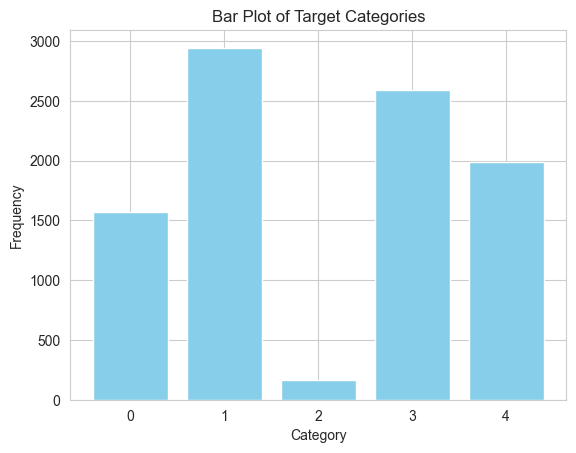

In [49]:
category_counts = topics_df['target_category'].value_counts().sort_index()

plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Bar Plot of Target Categories')
plt.show()

## Real categories and their labels ##
**artificial intelligence  - 0**   
**biographies  - 1**       
**movies about artificial intelligence  - 2** 
**philosophy   - 3**                          
**programming  - 4**                     

In [50]:
label_encoder = LabelEncoder()
topics_df["is_org"] = label_encoder.fit_transform(topics_df["is_org"])
topics_df["is_product"] = label_encoder.fit_transform(topics_df["is_product"])
topics_df["is_person"] = label_encoder.fit_transform(topics_df["is_person"])

topics_df.head(10)

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,is_org,is_product,is_person,target_category
0,428209002237,Ramsay was born in Glasgow on 2 October 1852. ...,ORG_YES_PRODUCT_NO_PERSON_YES_,49,12.0,man,biographies,1,0,1,1
1,564218010072,It has been widely estimated for at least the ...,ORG_YES_PRODUCT_NO_PERSON_NO_,166,47.0,man,artificial intelligence,1,0,0,0
2,291401001672,He went on to win the Royal Medal of the Royal...,ORG_YES_PRODUCT_NO_PERSON_NO_,69,18.0,non-binary,biographies,1,0,0,1
3,31548004883,The changes have altered many underlying assum...,ORG_NO_PRODUCT_YES_PERSON_NO_,76,27.0,non-binary,programming,0,1,0,4
4,50634005146,"After these novels were published, Disraeli de...",ORG_YES_PRODUCT_YES_PERSON_YES_,200,47.0,man,biographies,1,1,1,1
5,220520007895,Philo also proposes that the order in nature m...,ORG_NO_PRODUCT_NO_PERSON_NO_,137,36.0,man,philosophy,0,0,0,3
6,6360003753,"This led to the AI spring of the early 2020s,...",ORG_YES_PRODUCT_NO_PERSON_NO_,116,47.0,man,artificial intelligence,1,0,0,0
7,848119011941,A second form of functionalism is based on the...,ORG_YES_PRODUCT_NO_PERSON_YES_,42,14.0,man,philosophy,1,0,1,3
8,49279000639,"The opposite of ""moral"" is ""immoral"", meaning ...",ORG_NO_PRODUCT_NO_PERSON_NO_,51,8.0,man,philosophy,0,0,0,3
9,79225005859,Pepys' diary provides a first-hand account of ...,ORG_NO_PRODUCT_YES_PERSON_YES_,139,31.0,man,biographies,0,1,1,1


### Cleaning text ###

Last steps before splitting data will be cleaning our paragraph column. We will remove new line charactes, emails, phone numbers and urls from the text.However we will keep punctuation until tokenization.

In [51]:
topics_df["paragraph"].str.contains("\n").sum()

0

It looks our paragraphs have not any new line characters. But it is better to clean the text

In [52]:
topics_df["paragraph"].value_counts()

paragraph
-1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

There are a couple of duplicate paragraphs and also 42 records with "-1" value, which should be removed immediately.

In [53]:
topics_encoded_df = topics_df[topics_df["paragraph"] != "-1"]
topics_encoded_df["paragraph"].value_counts()

paragraph
The theory is associated with Mencius and Wang Yangming. It contrasts with Xunzi's Theory of Evil Human Nature.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

So there are still some duplicate values. Let's remove them too.

In [54]:
topics_df = topics_df.drop_duplicates(subset=["paragraph"])

In [55]:
topics_df["paragraph"].duplicated().sum()

0

Now there are no duplicate records

In [56]:
from cleantext import clean


def text_cleaner(text):
    return clean(text,
                 fix_unicode=True,
                 to_ascii=True,
                 lower=True,
                 no_line_breaks=True,
                 no_urls=True,
                 replace_with_url="",
                 no_emails=True,
                 replace_with_email="",
                 no_phone_numbers=True,
                 no_punct=False,
                 replace_with_phone_number="",
                 lang="en")


In [38]:
topics_encoded_df["clean_paragraph"] = topics_encoded_df["paragraph"].apply(text_cleaner)
topics_encoded_df.head(10)

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,is_org,is_product,is_person,target_category,clean_paragraph
0,428209002237,Ramsay was born in Glasgow on 2 October 1852. ...,ORG_YES_PRODUCT_NO_PERSON_YES_,49,12.0,man,biographies,1,0,1,1,ramsay was born in glasgow on 2 october 1852. ...
1,564218010072,It has been widely estimated for at least the ...,ORG_YES_PRODUCT_NO_PERSON_NO_,166,47.0,man,artificial intelligence,1,0,0,0,it has been widely estimated for at least the ...
2,291401001672,He went on to win the Royal Medal of the Royal...,ORG_YES_PRODUCT_NO_PERSON_NO_,69,18.0,non-binary,biographies,1,0,0,1,he went on to win the royal medal of the royal...
3,31548004883,The changes have altered many underlying assum...,ORG_NO_PRODUCT_YES_PERSON_NO_,76,27.0,non-binary,programming,0,1,0,4,the changes have altered many underlying assum...
4,50634005146,"After these novels were published, Disraeli de...",ORG_YES_PRODUCT_YES_PERSON_YES_,200,47.0,man,biographies,1,1,1,1,"after these novels were published, disraeli de..."
5,220520007895,Philo also proposes that the order in nature m...,ORG_NO_PRODUCT_NO_PERSON_NO_,137,36.0,man,philosophy,0,0,0,3,philo also proposes that the order in nature m...
6,6360003753,"This led to the AI spring of the early 2020s,...",ORG_YES_PRODUCT_NO_PERSON_NO_,116,47.0,man,artificial intelligence,1,0,0,0,"this led to the ai spring of the early 2020s, ..."
7,848119011941,A second form of functionalism is based on the...,ORG_YES_PRODUCT_NO_PERSON_YES_,42,14.0,man,philosophy,1,0,1,3,a second form of functionalism is based on the...
8,49279000639,"The opposite of ""moral"" is ""immoral"", meaning ...",ORG_NO_PRODUCT_NO_PERSON_NO_,51,8.0,man,philosophy,0,0,0,3,"the opposite of ""moral"" is ""immoral"", meaning ..."
9,79225005859,Pepys' diary provides a first-hand account of ...,ORG_NO_PRODUCT_YES_PERSON_YES_,139,31.0,man,biographies,0,1,1,1,pepys' diary provides a first-hand account of ...


Before splitting our data it is good idea to drop unnecessary columns.

In [39]:
drop_columns = ["par_id", "paragraph", "has_entity", "lexicon_count", "difficult_words", "last_editor_gender",
                "category"]

classification_df = topics_encoded_df.drop(drop_columns, axis=1)
classification_df.head()

,is_org,is_product,is_person,target_category,clean_paragraph
0,1,0,1,1,ramsay was born in glasgow on 2 october 1852. ...
1,1,0,0,0,it has been widely estimated for at least the ...
2,1,0,0,1,he went on to win the royal medal of the royal...
3,0,1,0,4,the changes have altered many underlying assum...
4,1,1,1,1,"after these novels were published, disraeli de..."


**Let's keep in mind real name of the categories**


0 - > artificial intelligence
1 - > biographies
2 - > movies about artificial intelligence
3 - > philosophy
4 - > programming

### Tokenization and Lemmatization ###

In [6]:
import string

EXTRA_PUNCT = string.punctuation


def get_tokens(text_):
    doc_ = nlp(text_)

    lemmas_ = [token.lemma_ for token in doc_ if not (token.is_stop or token.is_punct or token.is_digit)]

    return [lemma for lemma in lemmas_ if lemma not in EXTRA_PUNCT]

In [41]:
classification_df["paragraph_tokens"] = classification_df["clean_paragraph"].apply(get_tokens)
classification_df.head(10)

,is_org,is_product,is_person,target_category,clean_paragraph,paragraph_tokens
0,1,0,1,1,ramsay was born in glasgow on 2 october 1852. ...,"[ramsay, bear, glasgow, october, nephew, geolo..."
1,1,0,0,0,it has been widely estimated for at least the ...,"[widely, estimate, generation, program, resour..."
2,1,0,0,1,he went on to win the royal medal of the royal...,"[go, win, royal, medal, royal, society, copley..."
3,0,1,0,4,the changes have altered many underlying assum...,"[change, alter, underlying, assumption, right,..."
4,1,1,1,1,"after these novels were published, disraeli de...","[novel, publish, disraeli, declare, write, tur..."
5,0,0,0,3,philo also proposes that the order in nature m...,"[philo, propose, order, nature, nature, nature..."
6,1,0,0,0,"this led to the ai spring of the early 2020s, ...","[lead, ai, spring, early, 2020s, company, univ..."
7,1,0,1,3,a second form of functionalism is based on the...,"[second, form, functionalism, base, rejection,..."
8,0,0,0,3,"the opposite of ""moral"" is ""immoral"", meaning ...","[opposite, moral, immoral, mean, wrong, thing,..."
9,0,1,1,1,pepys' diary provides a first-hand account of ...,"[pepys, diary, provide, hand, account, restora..."


In [7]:
def join_tokens(text):
    return " ".join([token for token in text])

In [43]:
classification_df["paragraph_tokens"] = classification_df["paragraph_tokens"].apply(join_tokens)
classification_df.head()

,is_org,is_product,is_person,target_category,clean_paragraph,paragraph_tokens
0,1,0,1,1,ramsay was born in glasgow on 2 october 1852. ...,ramsay bear glasgow october nephew geologist s...
1,1,0,0,0,it has been widely estimated for at least the ...,widely estimate generation program resource de...
2,1,0,0,1,he went on to win the royal medal of the royal...,go win royal medal royal society copley medal ...
3,0,1,0,4,the changes have altered many underlying assum...,change alter underlying assumption right thing...
4,1,1,1,1,"after these novels were published, disraeli de...",novel publish disraeli declare write turn atte...


### Word Embadding ###

In [8]:
def get_vector(text):
    doc = nlp(text)

    return doc.vector

In [45]:
paragraphs_emb = classification_df['paragraph_tokens'].apply(lambda record: pd.Series(get_vector(record)))
paragraphs_emb.columns = paragraphs_emb.columns.astype(str)
paragraphs_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-1.157693,-1.020012,-1.129373,-0.671885,0.400656,-0.483430,0.924603,1.537271,0.176636,0.993480,...,2.000800,-0.478438,-0.764103,-0.182948,-1.482199,-0.255730,0.577740,0.391280,-0.888048,0.770350
1,-0.918753,0.521393,-2.017159,0.689446,2.673309,0.494481,0.748932,2.749953,-2.060254,-1.220784,...,0.820044,-0.430838,-1.715879,0.421248,-0.965934,0.125903,0.282630,-1.983262,-0.919105,1.362927
2,-1.049657,-1.071924,0.516035,-0.616500,2.473487,-0.721932,0.307924,3.187718,-0.221691,0.549901,...,1.602302,0.151102,-1.322110,0.700559,-1.062849,-0.264832,1.051046,-0.478491,0.079895,-0.616940
3,-1.026348,0.064635,0.033977,0.741809,2.961195,0.482402,1.730606,3.500923,-3.388722,-0.056946,...,0.569282,-0.409963,0.962567,-0.309594,-0.823355,0.306531,0.456357,-2.575448,-2.051674,1.865638
4,-0.882517,-0.066808,-0.843714,0.258352,2.533143,-0.268865,1.466844,2.342812,-1.762919,-0.842052,...,2.116288,-1.180721,-0.448334,-0.150819,-0.929698,0.137730,0.995691,-0.964865,-1.727982,1.105931


We got out vector embeddings. Now let's join all our feature columns

In [46]:
classification_df = paragraphs_emb.join(classification_df)
classification_df.head()

,0,1,2,3,4,5,6,7,8,9,...,296,297,298,299,is_org,is_product,is_person,target_category,clean_paragraph,paragraph_tokens
0,-1.157693,-1.020012,-1.129373,-0.671885,0.400656,-0.483430,0.924603,1.537271,0.176636,0.993480,...,0.577740,0.391280,-0.888048,0.770350,1,0,1,1,ramsay was born in glasgow on 2 october 1852. ...,ramsay bear glasgow october nephew geologist s...
1,-0.918753,0.521393,-2.017159,0.689446,2.673309,0.494481,0.748932,2.749953,-2.060254,-1.220784,...,0.282630,-1.983262,-0.919105,1.362927,1,0,0,0,it has been widely estimated for at least the ...,widely estimate generation program resource de...
2,-1.049657,-1.071924,0.516035,-0.616500,2.473487,-0.721932,0.307924,3.187718,-0.221691,0.549901,...,1.051046,-0.478491,0.079895,-0.616940,1,0,0,1,he went on to win the royal medal of the royal...,go win royal medal royal society copley medal ...
3,-1.026348,0.064635,0.033977,0.741809,2.961195,0.482402,1.730606,3.500923,-3.388722,-0.056946,...,0.456357,-2.575448,-2.051674,1.865638,0,1,0,4,the changes have altered many underlying assum...,change alter underlying assumption right thing...
4,-0.882517,-0.066808,-0.843714,0.258352,2.533143,-0.268865,1.466844,2.342812,-1.762919,-0.842052,...,0.995691,-0.964865,-1.727982,1.105931,1,1,1,1,"after these novels were published, disraeli de...",novel publish disraeli declare write turn atte...


### Vectorization using TfIdfVectorizer ### 

don't run if already run get_vector function

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=300)
tfidf_vectors = tfidf_vectorizer.fit_transform(topics_df["paragraph"])
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()

In [ ]:
columns = ["target_category", "is_org", "is_product", "is_person"]
classification_df = pd.concat([classification_df[columns], tfidf_df], axis=1)
classification_df.head()

### Data Splitting ###

### Final check before splitting the data ###

In [47]:
classification_df.dropna(inplace=True)

In [48]:
classification_df.isna().sum()

0                   0
1                   0
2                   0
3                   0
4                   0
                   ..
is_product          0
is_person           0
target_category     0
clean_paragraph     0
paragraph_tokens    0
Length: 306, dtype: int64

In [49]:
drop_columns = ["clean_paragraph", "paragraph_tokens", "target_category"]

X = classification_df.drop(columns=drop_columns)  #
y = classification_df[["target_category"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Over Sampling ###

In [50]:
classification_df["target_category"].value_counts()

target_category
1    2934
3    2582
4    1975
0    1563
2     166
Name: count, dtype: int64

Category "biographies"(1) and "philosophy"(3) are pretty balanced but other three are unbalanced. However, we can try to oversample other three categories, namely "programming"(4), "artificial intelligence"(0) and "programming"(2)

In [51]:
over_sampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = over_sampler.fit_resample(X_train, y_train)

In [52]:
print(len(X_oversampled), len(y_oversampled))

9300 9300


So we have same number of records in our feature column and target column

### Trivial baseline assessment ##

                                      precision    recall  f1-score   support

             artificial intelligence       0.15      0.18      0.16       319
                         biographies       0.32      0.20      0.25       600
movies about artificial intelligence       0.01      0.17      0.03        29
                          philosophy       0.27      0.19      0.22       494
                         programming       0.23      0.22      0.22       402

                            accuracy                           0.20      1844
                           macro avg       0.20      0.19      0.18      1844
                        weighted avg       0.25      0.20      0.22      1844


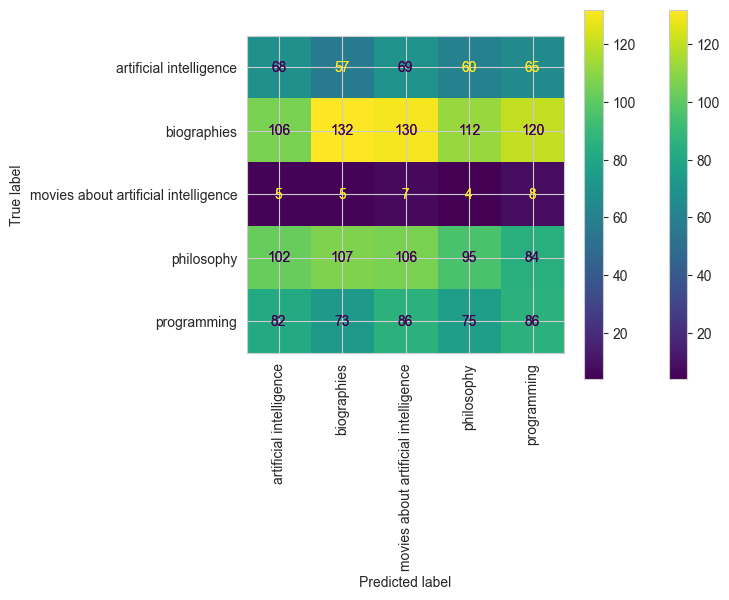

In [54]:
from sklearn.dummy import DummyClassifier

target_names = ["artificial intelligence", "biographies", "movies about artificial intelligence", "philosophy",
                "programming"]

trivial_clf = DummyClassifier(strategy="uniform")
trivial_clf.fit(X_train, y_train)

y_trivial = trivial_clf.predict(X_test)
print(classification_report(y_test, y_trivial, target_names=target_names))

cm = ConfusionMatrixDisplay.from_estimator(trivial_clf, X_test, y_test, display_labels=target_names)
cm.plot(xticks_rotation='vertical', values_format='d', ax=plt.gca())

Let's create our Column Transformer and use some normalization and standardization techniques

In [53]:
ct = ColumnTransformer(
    transformers=[
        (
            "scaling",
            StandardScaler(),
            [str(i) for i in range(300)],  # tfidf_vectorizer.get_feature_names_out()
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

Now time to create our Pipeline

### Fitting the model and Hyper parameter tuning ###


In [64]:
import warnings

warnings.simplefilter("ignore")

In [65]:
from time import time as tt

t0 = tt()

clf_pipe = Pipeline(
    steps=[
        ('scaling', ct),
        ('clf_pipe', MLPClassifier()),
    ]
)

parameters = {
    'clf_pipe__hidden_layer_sizes': ((40, 40), (50, 50), (60, 60,), (70, 70,), (80, 80,), (90, 90)),
    'clf_pipe__learning_rate_init': [0.0001, 0.001, 0.01],
}

clf_search = GridSearchCV(clf_pipe, parameters, scoring="accuracy", cv=5)

clf_search.fit(X_oversampled, y_oversampled)
print("Best score: ", clf_search.best_score_, clf_search.best_params_)
print(f'Time elapsed is {(tt() - t0):.2f} seconds')

best_clf = clf_search.best_estimator_

Best score:  0.9473118279569894 {'clf_pipe__hidden_layer_sizes': (70, 70), 'clf_pipe__learning_rate_init': 0.01}
Time elapsed is 764.22 seconds


In [66]:
clf_cv_results = pd.DataFrame(clf_search.cv_results_)
clf_cv_results.head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_pipe__hidden_layer_sizes,param_clf_pipe__learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.439122,4.242542,0.031641,0.005669,"(40, 40)",0.0001,"{'clf_pipe__hidden_layer_sizes': (40, 40), 'cl...",0.933871,0.925806,0.938172,0.946237,0.955376,0.939892,0.010175,16
1,6.462330,1.346955,0.038545,0.013797,"(40, 40)",0.001,"{'clf_pipe__hidden_layer_sizes': (40, 40), 'cl...",0.934946,0.932258,0.934946,0.947849,0.964516,0.942903,0.012096,6
2,3.495499,0.236870,0.037696,0.002632,"(40, 40)",0.01,"{'clf_pipe__hidden_layer_sizes': (40, 40), 'cl...",0.932258,0.925269,0.937634,0.951613,0.962366,0.941828,0.013423,11
3,14.832554,4.465625,0.129204,0.203329,"(50, 50)",0.0001,"{'clf_pipe__hidden_layer_sizes': (50, 50), 'cl...",0.936022,0.927419,0.937634,0.948387,0.963441,0.942581,0.012379,9
4,3.811703,0.090769,0.030042,0.004368,"(50, 50)",0.001,"{'clf_pipe__hidden_layer_sizes': (50, 50), 'cl...",0.932796,0.929032,0.936022,0.943011,0.962903,0.940753,0.011990,14
5,2.255861,0.416349,0.027349,0.004220,"(50, 50)",0.01,"{'clf_pipe__hidden_layer_sizes': (50, 50), 'cl...",0.921505,0.927957,0.943011,0.951613,0.961828,0.941183,0.014836,13
6,17.041145,3.016318,0.037148,0.008958,"(60, 60)",0.0001,"{'clf_pipe__hidden_layer_sizes': (60, 60), 'cl...",0.934409,0.929570,0.941398,0.947849,0.961290,0.942903,0.011088,6
7,4.662017,0.190776,0.040156,0.011244,"(60, 60)",0.001,"{'clf_pipe__hidden_layer_sizes': (60, 60), 'cl...",0.939247,0.925806,0.940323,0.951613,0.966667,0.944731,0.013683,5
8,2.990740,0.342272,0.033235,0.004839,"(60, 60)",0.01,"{'clf_pipe__hidden_layer_sizes': (60, 60), 'cl...",0.933333,0.934946,0.932796,0.916667,0.962903,0.936129,0.014940,18
9,17.864924,0.484440,0.034197,0.004323,"(70, 70)",0.0001,"{'clf_pipe__hidden_layer_sizes': (70, 70), 'cl...",0.933871,0.927419,0.934946,0.947849,0.962366,0.941290,0.012449,12


In [67]:
print(clf_cv_results[['mean_test_score'] + [t for t in clf_cv_results.columns if 'param' in t]])

    mean_test_score param_clf_pipe__hidden_layer_sizes  \
0          0.939892                           (40, 40)   
1          0.942903                           (40, 40)   
2          0.941828                           (40, 40)   
3          0.942581                           (50, 50)   
4          0.940753                           (50, 50)   
5          0.941183                           (50, 50)   
6          0.942903                           (60, 60)   
7          0.944731                           (60, 60)   
8          0.936129                           (60, 60)   
9          0.941290                           (70, 70)   
10         0.947312                           (70, 70)   
11         0.947312                           (70, 70)   
12         0.942796                           (80, 80)   
13         0.942581                           (80, 80)   
14         0.937419                           (80, 80)   
15         0.944946                           (90, 90)   
16         0.9

### Evaluating trained model using validation data ### 

Validation Accuracy: 0.8983739837398373
Classification Report:
                                      precision    recall  f1-score   support

             artificial intelligence       0.85      0.84      0.85       248
                         biographies       0.92      0.91      0.91       474
movies about artificial intelligence       0.90      0.84      0.87        31
                          philosophy       0.88      0.91      0.89       415
                         programming       0.93      0.92      0.93       308

                            accuracy                           0.90      1476
                           macro avg       0.90      0.88      0.89      1476
                        weighted avg       0.90      0.90      0.90      1476

Confusion Matrix:


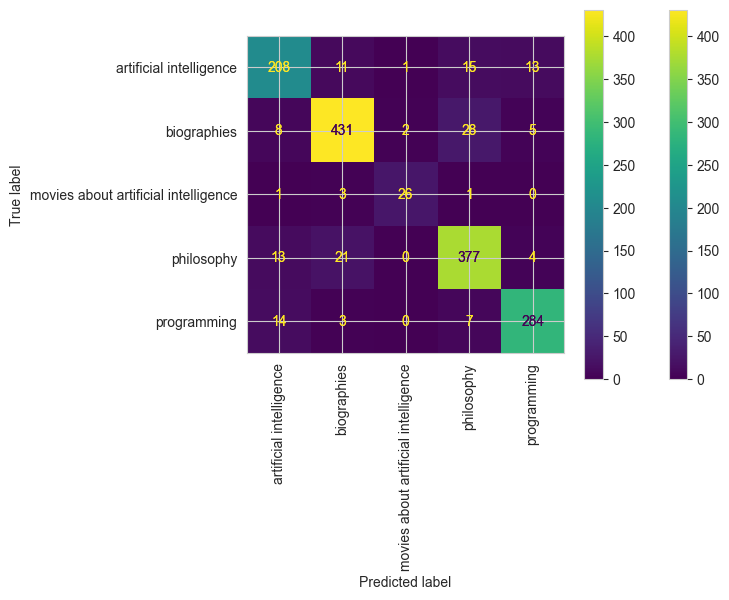

In [68]:
target_names = ["artificial intelligence", "biographies", "movies about artificial intelligence", "philosophy",
                "programming"]

# Evaluate on validation data
val_predictions = best_clf.predict(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_val, val_predictions, target_names=target_names))

# Confusion matrix
print("Confusion Matrix:")
cm = ConfusionMatrixDisplay.from_estimator(best_clf, X_val, y_val, display_labels=target_names)
cm.plot(xticks_rotation='vertical', values_format='d', ax=plt.gca())

#hyper parameters with TfIdf Vectorizor => 0.3349217154526889

#### Time to train using test (unseen) data ####

                                      precision    recall  f1-score   support

             artificial intelligence       0.87      0.85      0.86       319
                         biographies       0.94      0.90      0.92       600
movies about artificial intelligence       0.93      0.97      0.95        29
                          philosophy       0.84      0.93      0.89       494
                         programming       0.95      0.92      0.94       402

                            accuracy                           0.90      1844
                           macro avg       0.91      0.91      0.91      1844
                        weighted avg       0.91      0.90      0.90      1844


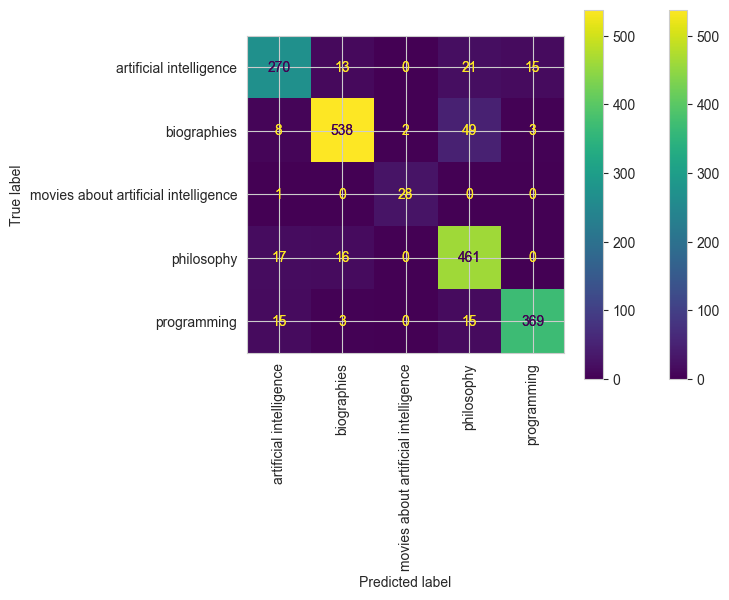

In [69]:
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

cm = ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test, display_labels=target_names)
cm.plot(xticks_rotation='vertical', values_format='d', ax=plt.gca())

## Real categories and their labels ##
**artificial intelligence  - 0**   
**biographies  - 1**       
**movies about artificial intelligence  - 2** 
**philosophy   - 3**                          
**programming  - 4**                     

###  2. Trying with CNN models ###

In [156]:
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer='l2'),
        Dense(32, activation='relu', kernel_regularizer='l2'),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [71]:
# Create a KerasClassifier wrapper for GridSearchCV
keras_model = KerasClassifier(model=create_model)

pipeline = Pipeline([
    ('scaler', ct),
    ('clf', keras_model)
])

# Define hyperparameters to tune
param_grid = {
    'clf__epochs': [10, 20, 30, 40, 50, 60, 70, 80],
    'clf__batch_size': [32, 64, 128]
}

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3)
grid_search.fit(X_oversampled, y_oversampled)
best_clf = grid_search.best_estimator_

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Epoch 1/10
194/194 [==============================] - 3s 2ms/step - loss: 1.6973 - accuracy: 0.8121
Epoch 2/10
194/194 [==============================] - 0s 2ms/step - loss: 0.9171 - accuracy: 0.9071
Epoch 3/10
194/194 [==============================] - 0s 2ms/step - loss: 0.6256 - accuracy: 0.9203
Epoch 4/10
194/194 [==============================] - 0s 2ms/step - loss: 0.4892 - accuracy: 0.9310
Epoch 5/10
194/194 [==============================] - 0s 2ms/step - loss: 0.4265 - accuracy: 0.9327
Epoch 6/10
194/194 [==============================] - 0s 2ms/step - loss: 0.3901 - accuracy: 0.9366
Epoch 7/10
194/194 [==============================] - 0s 2ms/step - loss: 0.3583 - accuracy: 0.9440
Epoch 8/10
194/194 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.9435
Epoch 9/10
194/194 [==============================] - 0s 2ms/step - loss: 0.3260 - accuracy: 0.9487
Epoch 10/10
97/97 [==============================] - 0s 1ms/step
Epoch 1/10
194/194 [===============

In [72]:
clf_cnn_results = pd.DataFrame(grid_search.cv_results_)
clf_cnn_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__batch_size,param_clf__epochs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.774183,1.003849,0.317442,0.063012,32,10,"{'clf__batch_size': 32, 'clf__epochs': 10}",0.914516,0.922581,0.923226,0.920108,0.003962,24
1,9.239165,0.249442,0.307478,0.027987,32,20,"{'clf__batch_size': 32, 'clf__epochs': 20}",0.920645,0.927097,0.930323,0.926022,0.004023,20
2,15.446919,4.387633,0.278396,0.010008,32,30,"{'clf__batch_size': 32, 'clf__epochs': 30}",0.923226,0.921935,0.937097,0.927419,0.006863,18
3,15.368708,0.094836,0.292183,0.017430,32,40,"{'clf__batch_size': 32, 'clf__epochs': 40}",0.916774,0.930968,0.944516,0.930753,0.011327,13
4,21.033978,0.793804,0.304501,0.018000,32,50,"{'clf__batch_size': 32, 'clf__epochs': 50}",0.928710,0.917419,0.942258,0.929462,0.010154,14
5,22.736028,0.868542,0.292180,0.015128,32,60,"{'clf__batch_size': 32, 'clf__epochs': 60}",0.917097,0.925806,0.942581,0.928495,0.010576,16
6,26.058276,0.314547,0.327016,0.019665,32,70,"{'clf__batch_size': 32, 'clf__epochs': 70}",0.917097,0.923226,0.941290,0.927204,0.010270,19
7,29.825930,0.496935,0.339450,0.046920,32,80,"{'clf__batch_size': 32, 'clf__epochs': 80}",0.925806,0.925161,0.949032,0.933333,0.011104,8
8,2.910018,0.343878,0.232241,0.029882,64,10,"{'clf__batch_size': 64, 'clf__epochs': 10}",0.920645,0.921613,0.932581,0.924946,0.005413,21
9,5.322268,0.642669,0.221163,0.007453,64,20,"{'clf__batch_size': 64, 'clf__epochs': 20}",0.924839,0.926774,0.945484,0.932366,0.009310,11


In [73]:
print(clf_cv_results[['mean_test_score'] + [t for t in clf_cv_results.columns if 'param' in t]])

    mean_test_score param_clf_pipe__hidden_layer_sizes  \
0          0.939892                           (40, 40)   
1          0.942903                           (40, 40)   
2          0.941828                           (40, 40)   
3          0.942581                           (50, 50)   
4          0.940753                           (50, 50)   
5          0.941183                           (50, 50)   
6          0.942903                           (60, 60)   
7          0.944731                           (60, 60)   
8          0.936129                           (60, 60)   
9          0.941290                           (70, 70)   
10         0.947312                           (70, 70)   
11         0.947312                           (70, 70)   
12         0.942796                           (80, 80)   
13         0.942581                           (80, 80)   
14         0.937419                           (80, 80)   
15         0.944946                           (90, 90)   
16         0.9

### Evaluating trained model using validation data ### 

12/12 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8861788617886179
Classification Report:
                                      precision    recall  f1-score   support

             artificial intelligence       0.82      0.85      0.84       248
                         biographies       0.92      0.89      0.90       474
movies about artificial intelligence       0.72      0.84      0.78        31
                          philosophy       0.89      0.88      0.89       415
                         programming       0.91      0.92      0.92       308

                            accuracy                           0.89      1476
                           macro avg       0.85      0.88      0.86      1476
                        weighted avg       0.89      0.89      0.89      1476

Confusion Matrix:
12/12 [==============================] - 0s 2ms/step


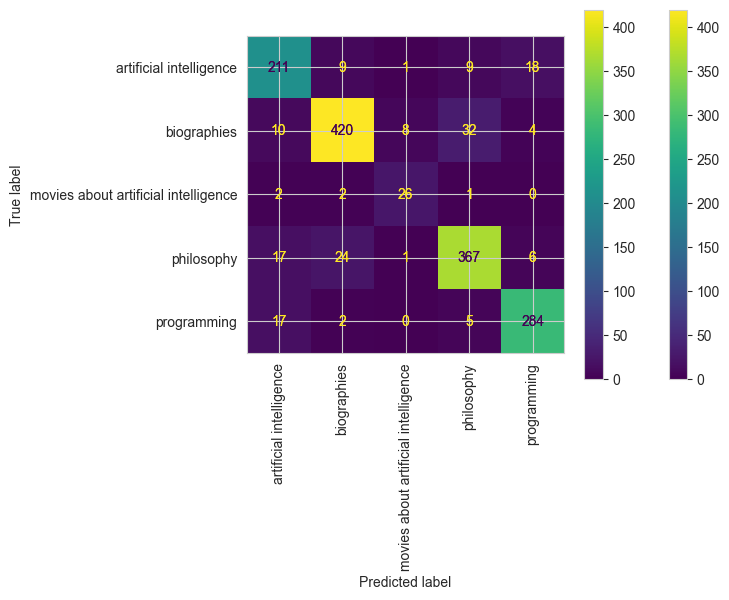

In [74]:
# Evaluate on validation data
val_predictions = best_clf.predict(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_val, val_predictions, target_names=target_names))

# Confusion matrix
print("Confusion Matrix:")
cm = ConfusionMatrixDisplay.from_estimator(best_clf, X_val, y_val, display_labels=target_names)
cm.plot(xticks_rotation='vertical', values_format='d', ax=plt.gca())


#### Time to train using test (unseen) data ####

15/15 [==============================] - 0s 3ms/step
Classification Report:
                                      precision    recall  f1-score   support

             artificial intelligence       0.86      0.89      0.87       319
                         biographies       0.95      0.88      0.92       600
movies about artificial intelligence       0.76      0.90      0.83        29
                          philosophy       0.87      0.93      0.90       494
                         programming       0.95      0.94      0.95       402

                            accuracy                           0.91      1844
                           macro avg       0.88      0.91      0.89      1844
                        weighted avg       0.91      0.91      0.91      1844

Confusion Matrix:
15/15 [==============================] - 0s 2ms/step


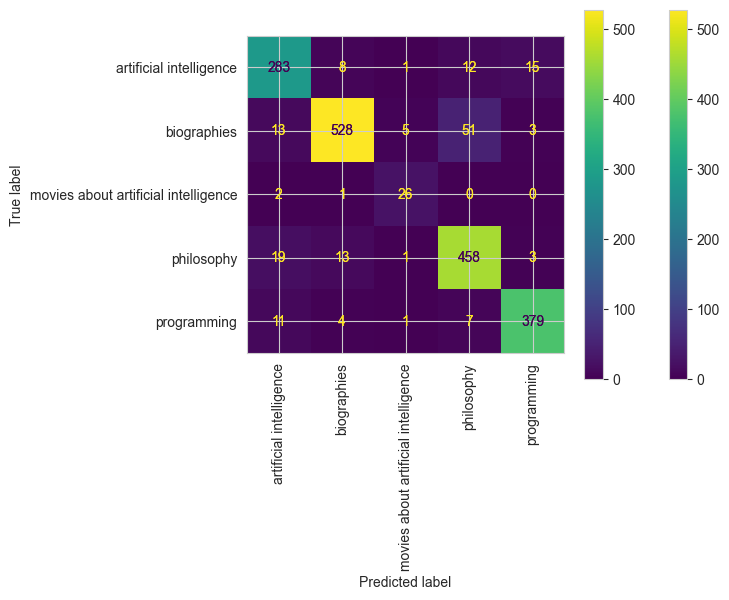

In [75]:
y_pred = best_clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
print("Confusion Matrix:")
cm = ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test, display_labels=target_names)
cm.plot(xticks_rotation='vertical', values_format='d', ax=plt.gca())

###  3. Trying with SGDClassifier model ###

In [76]:
sgd_parameter = {'classifier__eta0': np.logspace(-5, -1, 3),
                 'classifier__learning_rate': ['constant'],
                 'classifier__alpha': [0.0001, 0.01, 0.1],
                 }

clf_pipe = Pipeline(
    steps=[('ct', ct),
           ('classifier', SGDClassifier(loss='log_loss', random_state=0)),
           ]
)

clf_search = GridSearchCV(clf_pipe, sgd_parameter, scoring="accuracy", cv=5)

clf_search.fit(X_oversampled, y_oversampled)
print("Best score: ", clf_search.best_score_, clf_search.best_params_)

best_clf = clf_search.best_estimator_

Best score:  0.909032258064516 {'classifier__alpha': 0.0001, 'classifier__eta0': 0.001, 'classifier__learning_rate': 'constant'}


In [77]:
clf_sgd_results = pd.DataFrame(clf_search.cv_results_)
clf_sgd_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__eta0,param_classifier__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.394536,1.345458,0.023068,0.002114,0.0001,0.00001,constant,"{'classifier__alpha': 0.0001, 'classifier__eta...",0.875269,0.873656,0.868817,0.886022,0.866667,0.874086,0.006736,5
1,0.954346,0.053652,0.022369,0.001261,0.0001,0.001,constant,"{'classifier__alpha': 0.0001, 'classifier__eta...",0.912366,0.902688,0.908602,0.916667,0.904839,0.909032,0.005048,1
2,0.639351,0.031940,0.022960,0.001276,0.0001,0.1,constant,"{'classifier__alpha': 0.0001, 'classifier__eta...",0.880645,0.879570,0.889247,0.888172,0.884409,0.884409,0.003877,3
3,2.724468,0.080109,0.032020,0.019275,0.01,0.00001,constant,"{'classifier__alpha': 0.01, 'classifier__eta0'...",0.874731,0.873118,0.867742,0.885484,0.866129,0.873441,0.006823,6
4,0.775012,0.032516,0.022870,0.001584,0.01,0.001,constant,"{'classifier__alpha': 0.01, 'classifier__eta0'...",0.908065,0.898387,0.898387,0.910753,0.901075,0.903333,0.005128,2
5,0.449075,0.042568,0.024342,0.004008,0.01,0.1,constant,"{'classifier__alpha': 0.01, 'classifier__eta0'...",0.795699,0.818280,0.765054,0.775269,0.768817,0.784624,0.019878,8
6,2.493169,0.092729,0.022472,0.001128,0.1,0.00001,constant,"{'classifier__alpha': 0.1, 'classifier__eta0':...",0.870968,0.865591,0.865054,0.880108,0.856452,0.867634,0.007779,7
7,0.587816,0.023160,0.022267,0.000654,0.1,0.001,constant,"{'classifier__alpha': 0.1, 'classifier__eta0':...",0.882258,0.875806,0.865591,0.884409,0.865054,0.874624,0.008107,4
8,0.442390,0.041090,0.022995,0.002012,0.1,0.1,constant,"{'classifier__alpha': 0.1, 'classifier__eta0':...",0.613441,0.656989,0.633333,0.679032,0.681720,0.652903,0.026344,9


In [78]:
print(clf_cv_results[['mean_test_score'] + [t for t in clf_cv_results.columns if 'param' in t]])

    mean_test_score param_clf_pipe__hidden_layer_sizes  \
0          0.939892                           (40, 40)   
1          0.942903                           (40, 40)   
2          0.941828                           (40, 40)   
3          0.942581                           (50, 50)   
4          0.940753                           (50, 50)   
5          0.941183                           (50, 50)   
6          0.942903                           (60, 60)   
7          0.944731                           (60, 60)   
8          0.936129                           (60, 60)   
9          0.941290                           (70, 70)   
10         0.947312                           (70, 70)   
11         0.947312                           (70, 70)   
12         0.942796                           (80, 80)   
13         0.942581                           (80, 80)   
14         0.937419                           (80, 80)   
15         0.944946                           (90, 90)   
16         0.9

### Evaluating trained model using validation data ### 

Validation Accuracy: 0.8773712737127372
Classification Report:
                                      precision    recall  f1-score   support

             artificial intelligence       0.78      0.83      0.80       248
                         biographies       0.94      0.89      0.91       474
movies about artificial intelligence       0.66      0.87      0.75        31
                          philosophy       0.87      0.88      0.88       415
                         programming       0.91      0.90      0.91       308

                            accuracy                           0.88      1476
                           macro avg       0.83      0.87      0.85      1476
                        weighted avg       0.88      0.88      0.88      1476

Confusion Matrix:


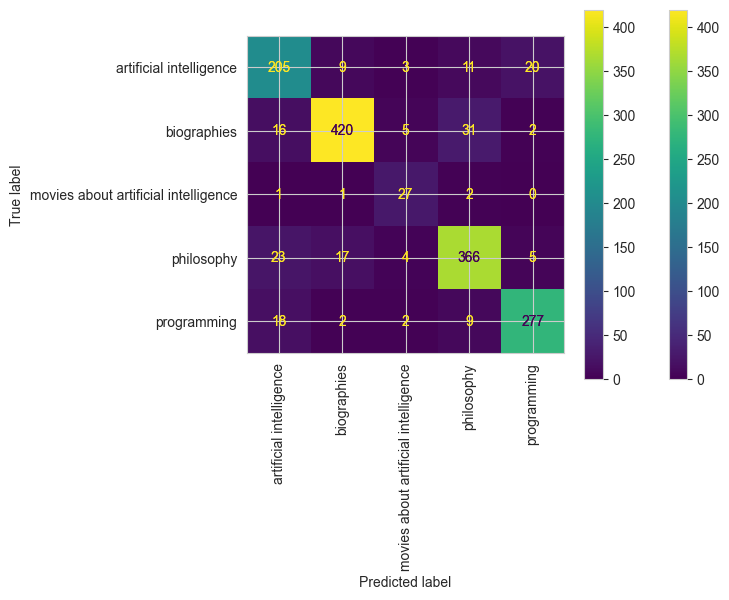

In [79]:
# Evaluate on validation data
val_predictions = best_clf.predict(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_val, val_predictions, target_names=target_names))

# Confusion matrix
print("Confusion Matrix:")
cm = ConfusionMatrixDisplay.from_estimator(best_clf, X_val, y_val, display_labels=target_names)
cm.plot(xticks_rotation='vertical', values_format='d', ax=plt.gca())


#### Time to train using test (unseen) data ####

Classification Report:
                                      precision    recall  f1-score   support

             artificial intelligence       0.81      0.86      0.84       319
                         biographies       0.95      0.86      0.90       600
movies about artificial intelligence       0.73      0.93      0.82        29
                          philosophy       0.84      0.90      0.87       494
                         programming       0.94      0.92      0.93       402

                            accuracy                           0.89      1844
                           macro avg       0.85      0.90      0.87      1844
                        weighted avg       0.89      0.89      0.89      1844

Confusion Matrix:


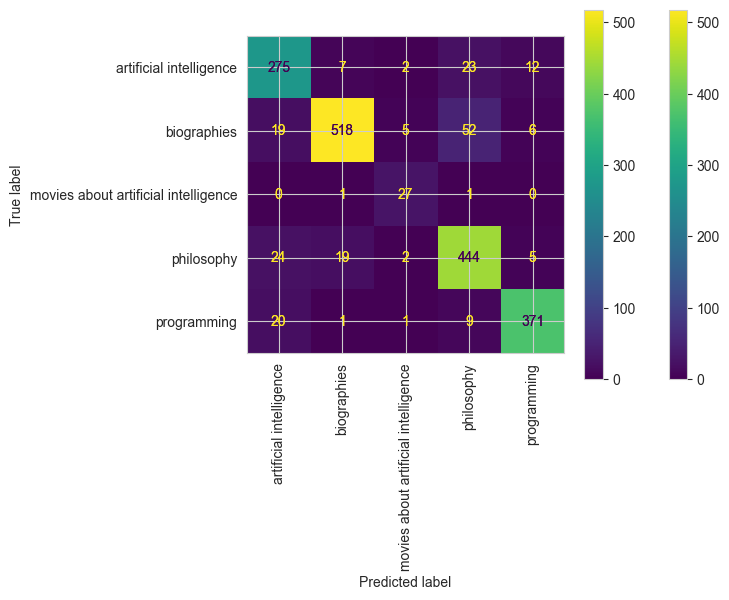

In [80]:
y_pred = best_clf.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
print("Confusion Matrix:")
cm = ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test, display_labels=target_names)
cm.plot(xticks_rotation='vertical', values_format='d', ax=plt.gca())

## Real categories and their labels ##
**artificial intelligence  - 0**   
**biographies  - 1**       
**movies about artificial intelligence  - 2** 
**philosophy   - 3**                          
**programming  - 4**                     

### Questions ###

### 1. Think about displaying some graphs on EDA step? ### okay 
### 2. Why we need has_entity as a feature?, ###
### 3. Does it okay to divide has_entity? like i did ### explanation
### 4. Should i use it when oversampling? ### only train dataset
### 5. What about text length, how it is helping me as a feature? ###
### 6. Ask about referencing code which i found from the internet ###
### 7. Can use other Tenserflow models for the coursework YES ### 
### 8. Is the chronology and steps are good? Can use this chronology in my report ? ###
### 9. Do i need lexicon_count and difficult_word features ###
### 10. Why model is performing bad on "movies about artificial intelligence" category ###
check with oversampling?  good analyzes
### 11. What do you think about "-1" and how can i increase accuracy ###

# Task 2 #

In [4]:
unlabelled_topics = pd.read_csv("comp1804_coursework_dataset_labelled.csv")
unlabelled_topics.sample(10)

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,text_clarity
6922,5.063401e+10,World events thereafter moved against the Cons...,ORG_YES_PRODUCT_NO_PERSON_YES_,89,31.0,woman,biographies,NaN
3673,6.350000e+11,"In 1741, he gave a paper to the Paris Academy ...",ORG_YES_PRODUCT_NO_PERSON_NO_,54,11.0,man,biographies,NaN
338,6.730000e+11,There are ways to exclude parts of the transcl...,ORG_NO_PRODUCT_NO_PERSON_NO_,30,6.0,man,programming,clear_enough
4510,1.330000e+11,Protagoras was one of the best known and most ...,ORG_YES_PRODUCT_NO_PERSON_YES_,125,26.0,prefer_not_to_say,philosophy,NaN
3270,7.628004e+09,"C has a very mature and broad ecosystem, inclu...",ORG_YES_PRODUCT_NO_PERSON_NO_,56,17.0,man,programming,NaN
9277,3.290000e+11,The definition of an exception is based on the...,ORG_NO_PRODUCT_NO_PERSON_NO_,138,39.0,woman,programming,NaN
2751,3.920000e+11,GOTO and GOSUB statements will search downward...,ORG_YES_PRODUCT_NO_PERSON_NO_,61,13.0,man,programming,NaN
8571,4.076004e+09,Software that could reverse CAPTCHA with some ...,ORG_YES_PRODUCT_NO_PERSON_NO_,24,8.0,man,artificial intelligence,NaN
3423,4.296700e+10,"reflection, i.e., the going back over differen...",ORG_NO_PRODUCT_NO_PERSON_NO_,19,5.0,man,philosophy,NaN
1000,2.432800e+10,The concept of karma in Hinduism developed and...,ORG_YES_PRODUCT_NO_PERSON_YES_,142,43.0,prefer_not_to_say,philosophy,NaN


## Using sem-supervised learning ##

#### 1. Data Exploration and assessment

In [5]:
unlabelled_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9347 entries, 0 to 9346
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   par_id              9347 non-null   float64
 1   paragraph           9347 non-null   object 
 2   has_entity          9347 non-null   object 
 3   lexicon_count       9347 non-null   int64  
 4   difficult_words     9329 non-null   float64
 5   last_editor_gender  9347 non-null   object 
 6   category            9287 non-null   object 
 7   text_clarity        498 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 584.3+ KB


#### Lest drop all null records and keep only labelled ones to use on semi-supervised learning ###

In [6]:
partially_labelled_df = unlabelled_topics.dropna()
partially_labelled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 497 entries, 0 to 498
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   par_id              497 non-null    float64
 1   paragraph           497 non-null    object 
 2   has_entity          497 non-null    object 
 3   lexicon_count       497 non-null    int64  
 4   difficult_words     497 non-null    float64
 5   last_editor_gender  497 non-null    object 
 6   category            497 non-null    object 
 7   text_clarity        497 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 34.9+ KB


#### Lets keep lexicon_count and difficult_words for now ####

In [45]:
columns_to_drop = ["par_id", "has_entity", "last_editor_gender", "category"]

partially_labelled_df = partially_labelled_df.drop(columns=columns_to_drop)
partially_labelled_df.sample(10)

,paragraph,lexicon_count,difficult_words,text_clarity
112,The theory of special relativity finds a conve...,169,34.0,clear_enough
138,"Hamilton, W. . ""Geometry for the selfish herd""...",17,7.0,clear_enough
417,"John Gould; A Monograph of the Ramphastidae, o...",32,4.0,not_clear_enough
389,"In other words, according to Rousseau, reason,...",98,31.0,clear_enough
318,Flash Lite 4: Added support for Flash 10 Actio...,19,6.0,clear_enough
9,Pepys' diary provides a first-hand account of ...,139,31.0,clear_enough
408,6 – while India was a major exception. Researc...,194,64.0,clear_enough
101,These arguments often center on what it means ...,56,17.0,clear_enough
246,The decoder is the second neural network of th...,64,14.0,clear_enough
118,Although Commodore BASIC supports signed integ...,89,27.0,clear_enough


In [7]:
partially_labelled_df["paragraph"].duplicated().sum()

1

In [8]:
partially_labelled_df = partially_labelled_df.drop_duplicates(subset=["paragraph"])
partially_labelled_df["paragraph"].duplicated().sum()

0

In [9]:
partially_labelled_df["lexicon_count"].isna().sum()

0

In [10]:
partially_labelled_df["difficult_words"].isna().sum()

0

In [11]:
partially_labelled_df["difficult_words"].isna().sum()

0

In [12]:
partially_labelled_df["text_clarity"].value_counts()

text_clarity
clear_enough        413
not_clear_enough     83
Name: count, dtype: int64

**Well, it is not balanced at all**

In [13]:
label_encoder = LabelEncoder()
partially_labelled_df["label"] = label_encoder.fit_transform(partially_labelled_df["text_clarity"])
partially_labelled_df.head()

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,text_clarity,label
0,4.280000e+11,Ramsay was born in Glasgow on 2 October 1852. ...,ORG_YES_PRODUCT_NO_PERSON_YES_,49,12.0,man,biographies,clear_enough,0
1,5.640000e+11,It has been widely estimated for at least the ...,ORG_YES_PRODUCT_NO_PERSON_NO_,166,47.0,man,artificial intelligence,not_clear_enough,1
2,2.910000e+11,He went on to win the Royal Medal of the Royal...,ORG_YES_PRODUCT_NO_PERSON_NO_,69,18.0,non-binary,biographies,clear_enough,0
3,3.154800e+10,The changes have altered many underlying assum...,ORG_NO_PRODUCT_YES_PERSON_NO_,76,27.0,non-binary,programming,clear_enough,0
4,5.063401e+10,"After these novels were published, Disraeli de...",ORG_YES_PRODUCT_YES_PERSON_YES_,200,47.0,man,biographies,not_clear_enough,1


### Real Label ### 
**clean enough =>  0**
**not clear enough =>  1**

In [19]:
labelled_features_df = partially_labelled_df[["paragraph", "difficult_words", "lexicon_count"]].copy()
labelled_features_df["clean_paragraph"] = labelled_features_df["paragraph"].apply(text_cleaner)
labelled_features_df = labelled_features_df.drop(columns=["paragraph"])
labelled_features_df.head()

,difficult_words,lexicon_count,clean_paragraph
0,12.0,49,ramsay was born in glasgow on 2 october 1852. ...
1,47.0,166,it has been widely estimated for at least the ...
2,18.0,69,he went on to win the royal medal of the royal...
3,27.0,76,the changes have altered many underlying assum...
4,47.0,200,"after these novels were published, disraeli de..."


In [20]:
unlabelled_df = unlabelled_topics[unlabelled_topics["text_clarity"].isna()]

drop_columns = ["par_id", "has_entity", "last_editor_gender", "category", "text_clarity"]
unlabelled_df = unlabelled_df.drop(columns=drop_columns)
unlabelled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8849 entries, 280 to 9346
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   paragraph        8849 non-null   object 
 1   lexicon_count    8849 non-null   int64  
 2   difficult_words  8832 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 276.5+ KB


In [21]:
unlabelled_df["difficult_words"].isna().sum()

17

In [22]:
imptr_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# how to solve one column problem when fitting the Simple Imputer 
# https://stackoverflow.com/questions/16782323/keep-selected-column-as-dataframe-instead-of-series
difficult_words_df = unlabelled_df["difficult_words"].to_frame()
imptr_num = imptr_num.fit(difficult_words_df)

unlabelled_df["difficult_words"] = imptr_num.transform(difficult_words_df)
unlabelled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8849 entries, 280 to 9346
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   paragraph        8849 non-null   object 
 1   lexicon_count    8849 non-null   int64  
 2   difficult_words  8849 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 276.5+ KB


Look like there is not any null values

In [23]:
unlabelled_df["clean_paragraph"] = unlabelled_df["paragraph"].apply(text_cleaner)
unlabelled_df = unlabelled_df.drop(columns=["paragraph"])
unlabelled_df.head()

,lexicon_count,difficult_words,clean_paragraph
280,58,20.0,the global partnership on artificial intellige...
499,107,38.0,schmidhuber noted that the resurgence of neura...
500,16,5.0,"so that both functions return a tuple, with th..."
501,33,12.0,wang yangming disagreed with the teachings of ...
502,57,17.0,another advantage of median is that it can be ...


### Tokenization and Vectorization of Labelled and Unlabelled datasets ###

In [24]:
labelled_features_df["paragraph_tokens"] = labelled_features_df["clean_paragraph"].apply(get_tokens)
labelled_features_df["paragraph_tokens"] = labelled_features_df["paragraph_tokens"].apply(join_tokens)
labelled_features_df = labelled_features_df.drop(columns=["clean_paragraph"])

#adding text length too
labelled_features_df["text_length"] = labelled_features_df["paragraph_tokens"].apply(len)

labelled_features_df.head()

,difficult_words,lexicon_count,paragraph_tokens,text_length
0,12.0,49,ramsay bear glasgow october nephew geologist s...,191
1,47.0,166,widely estimate generation program resource de...,701
2,18.0,69,go win royal medal royal society copley medal ...,284
3,27.0,76,change alter underlying assumption right thing...,335
4,47.0,200,novel publish disraeli declare write turn atte...,714


In [25]:
paragraphs_emb = labelled_features_df['paragraph_tokens'].apply(lambda record: pd.Series(get_vector(record)))
paragraphs_emb.columns = paragraphs_emb.columns.astype(str)

labelled_features_df = paragraphs_emb.join(labelled_features_df)

labelled_features_df = labelled_features_df.drop(columns=["paragraph_tokens"])
labelled_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,difficult_words,lexicon_count,text_length
0,-1.157693,-1.020012,-1.129373,-0.671885,0.400656,-0.483430,0.924603,1.537271,0.176636,0.993480,...,-0.182948,-1.482199,-0.255730,0.577740,0.391280,-0.888048,0.770350,12.0,49,191
1,-0.918753,0.521393,-2.017159,0.689446,2.673309,0.494481,0.748932,2.749953,-2.060254,-1.220784,...,0.421248,-0.965934,0.125903,0.282630,-1.983262,-0.919105,1.362927,47.0,166,701
2,-1.049657,-1.071924,0.516035,-0.616500,2.473487,-0.721932,0.307924,3.187718,-0.221691,0.549901,...,0.700559,-1.062849,-0.264832,1.051046,-0.478491,0.079895,-0.616940,18.0,69,284
3,-1.026348,0.064635,0.033977,0.741809,2.961195,0.482402,1.730606,3.500923,-3.388722,-0.056946,...,-0.309594,-0.823355,0.306531,0.456357,-2.575448,-2.051674,1.865638,27.0,76,335
4,-0.882517,-0.066808,-0.843714,0.258352,2.533143,-0.268865,1.466844,2.342812,-1.762919,-0.842052,...,-0.150819,-0.929698,0.137730,0.995691,-0.964865,-1.727982,1.105931,47.0,200,714


In [26]:
unlabelled_df["paragraph_tokens"] = unlabelled_df["clean_paragraph"].apply(get_tokens)
unlabelled_df["paragraph_tokens"] = unlabelled_df["paragraph_tokens"].apply(join_tokens)
unlabelled_df = unlabelled_df.drop(columns=["clean_paragraph"])

#adding text length too
unlabelled_df["text_length"] = unlabelled_df["paragraph_tokens"].apply(len)

unlabelled_df.head()

,lexicon_count,difficult_words,paragraph_tokens,text_length
280,58,20.0,global partnership artificial intelligence lau...,279
499,107,38.0,schmidhuber note resurgence neural network cen...,523
500,16,5.0,function return tuple result application integer,48
501,33,12.0,wang yangming disagree teaching zhu xi famous ...,156
502,57,17.0,advantage median calculate soon study survival...,226


In [27]:
paragraphs_emb = unlabelled_df['paragraph_tokens'].apply(lambda record: pd.Series(get_vector(record)))
paragraphs_emb.columns = paragraphs_emb.columns.astype(str)

unlabelled_df = paragraphs_emb.join(unlabelled_df)

unlabelled_df = unlabelled_df.drop(columns=["paragraph_tokens"])
unlabelled_df.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,lexicon_count,difficult_words,text_length
280,-0.311395,0.450434,-1.654913,0.827141,1.594313,0.132518,0.426609,1.533783,-1.885945,-0.494089,...,-0.610300,-1.856818,-0.605813,0.130459,-1.974525,-0.519726,2.035295,58,20.0,279
499,-1.251601,0.641573,-0.235250,1.282688,2.499720,-0.105074,1.420826,3.628194,-2.317965,-0.524704,...,-0.264131,-0.773705,0.720784,0.730259,-1.690483,-0.483928,1.834259,107,38.0,523
500,-1.818357,0.547960,1.424802,1.797020,4.474700,2.030287,0.590170,3.091785,-1.215753,-0.820645,...,0.431252,-0.668612,1.468839,1.589583,-4.054645,-1.187317,1.583845,16,5.0,48
501,-0.501804,0.651798,-0.503936,-0.483036,1.070128,0.466713,1.176789,1.625015,-1.514580,-0.536406,...,-1.273195,-0.716727,-0.540501,1.337764,-0.452632,-2.237265,1.402831,33,12.0,156
502,-0.634762,0.588822,-0.867579,0.204249,2.067203,-0.909390,1.060511,3.410865,-1.698542,-0.126763,...,-0.101824,-0.194154,-0.363122,-0.181259,-1.342819,-1.109725,0.508072,57,17.0,226


In [28]:
import warnings

warnings.simplefilter("ignore")

**Need to reorder column because columns number and order should be same in both labelled or unlabelled datasets for training**

In [29]:
extra_columns = ["difficult_words", "lexicon_count", "text_length"]
column_order = [str(i) for i in range(0, 300)] + extra_columns
#+ extra_columns
unlabelled_df_ordered = unlabelled_df[column_order]

In [45]:
column_transformer = ColumnTransformer([
    ("std", StandardScaler(), [str(i) for i in range(0, 300)]),
    ("minmax", MinMaxScaler(), ["difficult_words", "lexicon_count", "text_length"])
], verbose_feature_names_out=False, remainder="passthrough")

# Define the logistic regression classifier
base_classifier = LogisticRegression()

# Create a pipeline that includes scaling and classification
pipeline = Pipeline([
    ("preprocessing", column_transformer),
    ("classifier", base_classifier)
])


In [ ]:
self_training_classifier = SelfTrainingClassifier(pipeline)
y_labeled = np.array(partially_labelled_df["label"])

# Train SelfTrainingClassifier on labeled data
self_training_classifier.fit(labelled_features_df, y_labeled)

# Use trained classifier to make predictions on unlabeled data
pseudo_labels = self_training_classifier.predict(unlabelled_df_ordered)

X_labeled_updated = pd.concat([labelled_features_df, unlabelled_df_ordered], ignore_index=True)
y_labeled_updated = pd.concat([pd.Series(y_labeled), pd.Series(pseudo_labels)], ignore_index=True)

# Retrain classifier on updated labeled dataset
self_training_classifier.fit(X_labeled_updated, y_labeled_updated)

# Evaluate final model on labeled data
y_pred = self_training_classifier.predict(labelled_features_df)
accuracy = accuracy_score(y_labeled, y_pred)
print("Accuracy on labeled data after self-training:", accuracy)

In [ ]:
conf_matrix = confusion_matrix(y_labeled, y_pred, target_names=["clean enough", "not clean enough"])
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report
print("Classification Report:")
print(classification_report(y_labeled, y_pred))

In [65]:
y_labelled_df = pd.DataFrame(y_labeled_updated, columns=["text_clarity"])

final_labeled_df = pd.concat([X_labeled_updated, y_labelled_df], axis=1)
final_labeled_df.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,text_clarity
6310,-0.411800,-0.126368,-3.191557,-1.247812,1.160877,3.075920,-0.396293,1.205074,-1.992962,-0.695330,...,-0.293451,-0.245550,-1.378717,-0.292558,0.175881,2.065496,-0.847890,-1.315545,1.331586,0
2665,-1.629713,0.424935,0.220921,0.711675,3.514498,0.656562,0.724039,2.736608,-2.482352,-0.866591,...,-0.019456,0.709542,0.168086,-1.560909,0.636746,1.059431,-2.608217,-1.132380,1.273259,0
626,-1.521952,-0.094229,0.838895,-0.621162,2.597966,-0.013514,1.924232,1.798624,-2.810799,0.312435,...,-2.143688,0.656704,-1.505175,-0.497978,-0.794912,1.662314,-1.502469,-1.692062,0.583746,0
3934,-1.515663,0.567610,-1.512654,1.046156,2.876796,0.832637,1.367181,2.359848,-0.176454,0.173061,...,-0.939400,-0.403872,0.481422,-0.276633,0.335462,0.350239,-0.976244,-1.624727,1.354552,0
1966,0.627467,1.990309,-0.452219,1.171889,1.408769,0.695255,0.800042,3.228715,-0.675471,-0.007012,...,-0.294274,-0.300616,0.077620,-1.192365,-0.695204,1.638033,-1.146249,-0.408307,1.792849,0
1386,-1.580459,1.793486,-0.816304,0.834187,2.774757,0.241068,1.728855,3.451902,-2.130042,0.161792,...,0.100462,1.581881,-1.307846,-0.668354,0.719815,0.444251,-0.959396,-1.800231,0.036243,0
3833,-0.764366,0.306153,-1.617827,0.570160,2.064748,0.206721,0.616370,1.827120,-0.828562,-0.128045,...,-0.412431,-0.671265,0.455143,-0.939291,0.338654,-0.204553,-1.331377,-1.078060,1.284276,0
6274,-0.597816,0.217689,-0.646058,0.195877,2.822893,0.838799,1.815036,3.640774,-2.588964,-0.283747,...,-1.853174,1.253509,-0.477462,-0.636684,-0.147889,0.865204,-2.381721,-1.404080,1.617077,1
181,0.358778,-0.120321,-0.720038,0.730018,3.487407,-1.218731,1.456854,4.558629,-3.443794,-0.123904,...,-0.804619,1.646642,-0.972173,-0.816221,-0.733997,1.166629,-2.774268,-1.448705,1.572065,0
516,-0.682312,-0.556121,-1.644668,-0.773075,1.462017,-0.018079,1.389583,2.380374,-0.323143,0.181216,...,-0.561977,-0.411659,-0.446819,-1.480516,-0.584923,0.404043,-0.030895,-2.027673,0.577887,0


In [66]:
unlabelled_data = unlabelled_topics[unlabelled_topics["text_clarity"].isna()]
unlabelled_data = unlabelled_data.drop_duplicates(subset=["paragraph"])

In [67]:
def predict_label(text):
    # Vectorize the text using the same vectorizer used during training
    text_vectorized = get_vector(text)
    text_vectorized = text_vectorized.reshape(1, -1)
    # Predict the label using the trained model
    predicted_label = self_training_classifier.predict(text_vectorized)
    return predicted_label[0]  # Return the predicted label


# Apply the predict_label function to each text in the DataFrame
unlabelled_data["predicted_label"] = unlabelled_data["paragraph"].apply(predict_label)

In [69]:
unlabelled_data["predicted_label"].value_counts()

predicted_label
0    8469
1      67
Name: count, dtype: int64

## Using pre-trained model XLNet ##

In [52]:
partially_labelled_df = pd.read_csv("comp1804_coursework_dataset_labelled.csv")

labeled_data = partially_labelled_df[partially_labelled_df['text_clarity'].notna()]
unlabeled_data = partially_labelled_df[partially_labelled_df['text_clarity'].isna()]

In [54]:
labeled_data = labeled_data[["paragraph", "text_clarity", "difficult_words", "lexicon_count"]]

In [55]:
labeled_data = labeled_data.drop_duplicates(subset=["paragraph"])

In [56]:
label_encoder = LabelEncoder()

labeled_data["clarity"] = label_encoder.fit_transform(labeled_data["text_clarity"])
labeled_data = labeled_data.drop(columns=["text_clarity"])

### Real Label ### 
**clean enough =>  0**
**not clear enough =>  1**

In [57]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 497 entries, 0 to 498
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   paragraph        497 non-null    object 
 1   difficult_words  496 non-null    float64
 2   lexicon_count    497 non-null    int64  
 3   clarity          497 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 19.4+ KB


In [58]:
unlabeled_data = unlabeled_data.drop_duplicates(subset=["paragraph"])
unlabeled_data.head()

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,text_clarity
280,6.360004e+09,The Global Partnership on Artificial Intellige...,ORG_YES_PRODUCT_NO_PERSON_YES_,58,20.0,woman,artificial intelligence,NaN
499,4.474201e+10,Schmidhuber noted that the resurgence of neura...,ORG_YES_PRODUCT_NO_PERSON_YES_,107,38.0,man,artificial intelligence,NaN
500,9.980000e+11,"So that both functions return a tuple, with th...",ORG_NO_PRODUCT_NO_PERSON_NO_,16,5.0,man,programming,NaN
501,1.000000e+12,Wang Yangming disagreed with the teachings of ...,ORG_NO_PRODUCT_NO_PERSON_YES_,33,12.0,man,philosophy,NaN
502,6.261200e+10,Another advantage of median is that it can be ...,ORG_NO_PRODUCT_NO_PERSON_NO_,57,17.0,man,artificial intelligence,NaN


In [60]:
from transformers import XLNetForSequenceClassification, XLNetTokenizer
from torch.utils.data import TensorDataset, DataLoader
import torch

In [73]:
# Prepare data
X = labeled_data["paragraph"]
y = labeled_data["clarity"]

# Split data into training, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(list(X), list(y), test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.5,
                                                                  random_state=42)

# Tokenize data
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
max_length = 300

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

# Create datasets
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']),
                            torch.tensor(val_encodings['attention_mask']),
                            torch.tensor(val_labels))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))

In [74]:
# Initialize XLNetForSequenceClassification model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training loop
for epoch in range(3):
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy on Validation Data: 0.82
Classification Report on Validation Data:
                  precision    recall  f1-score   support

    clear enough       0.85      0.95      0.90        42
not clear enough       0.33      0.12      0.18         8

        accuracy                           0.82        50
       macro avg       0.59      0.54      0.54        50
    weighted avg       0.77      0.82      0.78        50


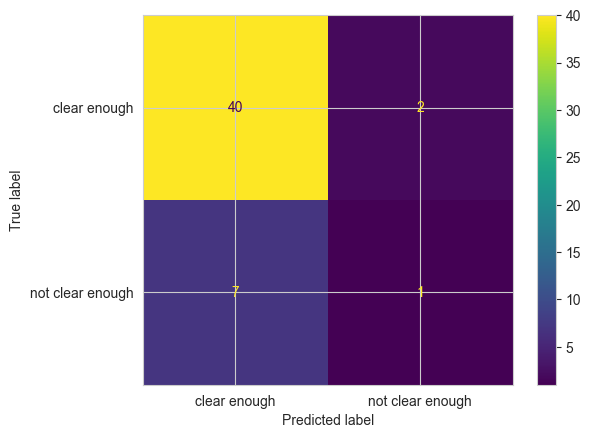

In [77]:
# Evaluation on validation data
target_names = ["clear enough", "not clear enough"]
val_loader = DataLoader(val_dataset, batch_size=8)

model.eval()
val_predictions = []

with torch.no_grad():
    for batch in val_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs.logits
        val_predictions.extend(logits.argmax(dim=-1).cpu().numpy())

val_accuracy = accuracy_score(val_labels, val_predictions)
print("Accuracy on Validation Data:", val_accuracy)

val_classification_report = classification_report(val_labels, val_predictions, target_names=target_names)
print("Classification Report on Validation Data:")
print(val_classification_report)

val_conf_matrix = confusion_matrix(val_labels, val_predictions)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=target_names)
confusion_matrix_display.plot()

Accuracy on Test Data: 0.88
Classification Report on Test Data:
                  precision    recall  f1-score   support

    clear enough       0.95      0.91      0.93        44
not clear enough       0.50      0.67      0.57         6

        accuracy                           0.88        50
       macro avg       0.73      0.79      0.75        50
    weighted avg       0.90      0.88      0.89        50

Confusion Matrix on Test Data:


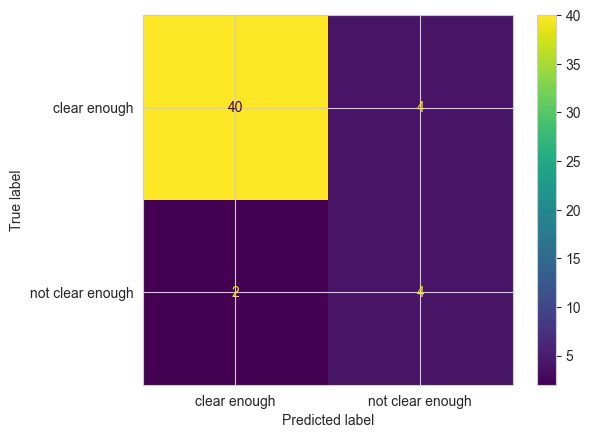

In [78]:
# Evaluation on test data
test_loader = DataLoader(test_dataset, batch_size=8)

test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs.logits
        test_predictions.extend(logits.argmax(dim=-1).cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy on Test Data:", test_accuracy)

test_classification_report = classification_report(test_labels, test_predictions, target_names=target_names)
print("Classification Report on Test Data:")
print(test_classification_report)

test_conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix on Test Data:")
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=target_names)
confusion_matrix_display.plot()

### Predicting labels for unlabeled data ###

In [0]:
# Tokenize unlabeled data
unlabeled_encodings = tokenizer(unlabeled_data['paragraph'].tolist(), truncation=True, padding=True,
                                max_length=max_length)
unlabeled_dataset = TensorDataset(torch.tensor(unlabeled_encodings['input_ids']),
                                  torch.tensor(unlabeled_encodings['attention_mask']))

# Evaluate model on unlabeled data and predict labels
model.eval()
predictions = []

with torch.no_grad():
    for batch in DataLoader(unlabeled_dataset, batch_size=8):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=-1).cpu().numpy())

In [110]:
# Convert predicted labels to strings
predicted_labels = ["clear_enough" if label == 0 else "not_clear_enough" for label in predictions]

labeled_df = partially_labelled_df[partially_labelled_df['text_clarity'].notna()]

unlabeled_df = partially_labelled_df[partially_labelled_df['text_clarity'].isna()]
unlabeled_df = unlabeled_df.drop_duplicates(subset=["paragraph"])
unlabeled_df["text_clarity"] = predicted_labels

In [111]:
final_labeled_dataset = pd.concat([labeled_df, unlabeled_df], ignore_index=True)
final_labeled_dataset.to_csv('final_labeled_dataset.csv', index=False)
final_labeled_dataset.sample(10)

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,text_clarity
2509,3.680000e+11,"The Weather Book, which he published in 1863,...",ORG_YES_PRODUCT_NO_PERSON_YES_,254,58.0,woman,biographies,clear_enough
7326,1.380000e+11,". Next, discrete recombination of the decisio...",ORG_NO_PRODUCT_NO_PERSON_NO_,29,11.0,man,artificial intelligence,not_clear_enough
7985,3.154000e+10,Several web-based simple BASIC interpreters al...,ORG_YES_PRODUCT_NO_PERSON_YES_,38,11.0,non-binary,programming,clear_enough
2512,4.500000e+11,"Colin Trevor Pillinger, was an English planet...",ORG_YES_PRODUCT_YES_PERSON_YES_,49,15.0,woman,biographies,clear_enough
6673,7.460000e+11,In addition to defining methods for a user-def...,ORG_NO_PRODUCT_NO_PERSON_NO_,98,26.0,man,programming,clear_enough
7968,1.030000e+12,Offline evaluations are based on historic data...,ORG_NO_PRODUCT_NO_PERSON_NO_,93,32.0,man,artificial intelligence,clear_enough
6770,8.020000e+11,Ruby-style string interpolation is included in...,ORG_NO_PRODUCT_NO_PERSON_NO_,19,9.0,man,programming,clear_enough
5977,6.740000e+11,""" Dubbing it Spielberg's ""first boring movie"",...",ORG_YES_PRODUCT_NO_PERSON_YES_,507,86.0,man,movies about artificial intelligence,clear_enough
7241,6.100000e+11,By introducing fuzzy inference in reinforcemen...,ORG_NO_PRODUCT_NO_PERSON_YES_,61,20.0,man,artificial intelligence,clear_enough
6299,9.980000e+11,When a programmer binds an IO value to a funct...,ORG_NO_PRODUCT_NO_PERSON_NO_,119,22.0,man,programming,clear_enough


## Now let's begin developing and training our model using labelled data ##

In [9]:
labelled_topics_df = pd.read_csv("final_labeled_dataset.csv")
labelled_topics_df.head()

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,text_clarity
0,4.280000e+11,Ramsay was born in Glasgow on 2 October 1852. ...,ORG_YES_PRODUCT_NO_PERSON_YES_,49,12.0,man,biographies,clear_enough
1,5.640000e+11,It has been widely estimated for at least the ...,ORG_YES_PRODUCT_NO_PERSON_NO_,166,47.0,man,artificial intelligence,not_clear_enough
2,2.910000e+11,He went on to win the Royal Medal of the Royal...,ORG_YES_PRODUCT_NO_PERSON_NO_,69,18.0,non-binary,biographies,clear_enough
3,3.154800e+10,The changes have altered many underlying assum...,ORG_NO_PRODUCT_YES_PERSON_NO_,76,27.0,non-binary,programming,clear_enough
4,5.063401e+10,"After these novels were published, Disraeli de...",ORG_YES_PRODUCT_YES_PERSON_YES_,200,47.0,man,biographies,not_clear_enough


In [10]:
labelled_topics_df["text_clarity"].value_counts()

text_clarity
clear_enough        8240
not_clear_enough     794
Name: count, dtype: int64

**Data is not balanced !**

In [11]:
label_encoder = LabelEncoder()
labelled_topics_df["text_clarity"] = label_encoder.fit_transform(labelled_topics_df["text_clarity"])
labelled_topics_df.head()

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,text_clarity
0,4.280000e+11,Ramsay was born in Glasgow on 2 October 1852. ...,ORG_YES_PRODUCT_NO_PERSON_YES_,49,12.0,man,biographies,0
1,5.640000e+11,It has been widely estimated for at least the ...,ORG_YES_PRODUCT_NO_PERSON_NO_,166,47.0,man,artificial intelligence,1
2,2.910000e+11,He went on to win the Royal Medal of the Royal...,ORG_YES_PRODUCT_NO_PERSON_NO_,69,18.0,non-binary,biographies,0
3,3.154800e+10,The changes have altered many underlying assum...,ORG_NO_PRODUCT_YES_PERSON_NO_,76,27.0,non-binary,programming,0
4,5.063401e+10,"After these novels were published, Disraeli de...",ORG_YES_PRODUCT_YES_PERSON_YES_,200,47.0,man,biographies,1


### Real labels ###
**clear_enough => 0**
**not_clear_enough => 1**

In [12]:
labelled_topics_df["clean_paragraph"] = labelled_topics_df["paragraph"].apply(text_cleaner)

In [13]:
labelled_topics_df["paragraph_tokens"] = labelled_topics_df["clean_paragraph"].apply(get_tokens)

In [14]:
labelled_topics_df["paragraph_tokens"] = labelled_topics_df["paragraph_tokens"].apply(join_tokens)

In [15]:
paragraphs_emb = labelled_topics_df['paragraph_tokens'].apply(lambda record: pd.Series(get_vector(record)))
paragraphs_emb.columns = paragraphs_emb.columns.astype(str)

labelled_topics_df = paragraphs_emb.join(labelled_topics_df)

In [16]:
drop_columns = ["par_id", "paragraph", "has_entity", "last_editor_gender", "category", "clean_paragraph",
                "paragraph_tokens"]
labeled_final_df = labelled_topics_df.drop(columns=drop_columns)

In [17]:
labeled_final_df = labeled_final_df.dropna(subset=["difficult_words"])
labeled_final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,lexicon_count,difficult_words,text_clarity
0,-1.157693,-1.020012,-1.129373,-0.671885,0.400656,-0.483430,0.924603,1.537271,0.176636,0.993480,...,-0.182948,-1.482199,-0.255730,0.577740,0.391280,-0.888048,0.770350,49,12.0,0
1,-0.918753,0.521393,-2.017159,0.689446,2.673309,0.494481,0.748932,2.749953,-2.060254,-1.220784,...,0.421248,-0.965934,0.125903,0.282630,-1.983262,-0.919105,1.362927,166,47.0,1
2,-1.049657,-1.071924,0.516035,-0.616500,2.473487,-0.721932,0.307924,3.187718,-0.221691,0.549901,...,0.700559,-1.062849,-0.264832,1.051046,-0.478491,0.079895,-0.616940,69,18.0,0
3,-1.026348,0.064635,0.033977,0.741809,2.961195,0.482402,1.730606,3.500923,-3.388722,-0.056946,...,-0.309594,-0.823355,0.306531,0.456357,-2.575448,-2.051674,1.865638,76,27.0,0
4,-0.882517,-0.066808,-0.843714,0.258352,2.533143,-0.268865,1.466844,2.342812,-1.762919,-0.842052,...,-0.150819,-0.929698,0.137730,0.995691,-0.964865,-1.727982,1.105931,200,47.0,1


**Now our dataset is ready**

### Splitting and Oversampling ###

In [18]:
X = labeled_final_df.drop(columns=["text_clarity"])  #
y = labeled_final_df["text_clarity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
over_sampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = over_sampler.fit_resample(X_train, y_train)

### Majority class baseline ###

                  precision    recall  f1-score   support

    clear enough       0.91      1.00      0.95      1642
not clear enough       0.00      0.00      0.00       162

        accuracy                           0.91      1804
       macro avg       0.46      0.50      0.48      1804
    weighted avg       0.83      0.91      0.87      1804


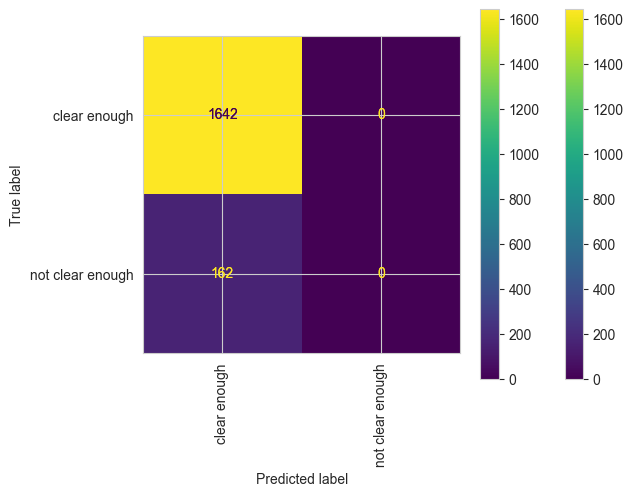

In [23]:
from sklearn.dummy import DummyClassifier
import warnings

warnings.simplefilter("ignore")

target_names = ["clear enough", "not clear enough"]

majority_clf = DummyClassifier(strategy='most_frequent')
majority_clf.fit(X_train, y_train)
y_pred_majority = majority_clf.predict(X_test)

print(classification_report(y_test, y_pred_majority, target_names=target_names))

cm = ConfusionMatrixDisplay.from_estimator(majority_clf, X_test, y_test, display_labels=target_names)
cm.plot(xticks_rotation='vertical', values_format='d', ax=plt.gca())


### Column transformer ###

In [150]:
ct = ColumnTransformer(
    transformers=[
        (
            "std_scaler",
            StandardScaler(),
            [str(i) for i in range(300)],
        ),
        (
            "minmax_scaler",
            MinMaxScaler(),
            ["lexicon_count", "difficult_words"],
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

### 1. Lets use MLPClassifier ###

In [151]:
import warnings

warnings.simplefilter("ignore")
from time import time as tt

t0 = tt()

clf_pipe = Pipeline(
    steps=[
        ('scaling', ct),
        ('clf_pipe', MLPClassifier()),
    ]
)

parameters = {
    'clf_pipe__hidden_layer_sizes': ((40, 40), (50, 50), (60, 60,), (70, 70,), (80, 80,), (90, 90)),
    'clf_pipe__learning_rate_init': [0.0001, 0.001, 0.01],
}

clf_search = GridSearchCV(clf_pipe, parameters, scoring="accuracy", cv=5)

clf_search.fit(X_oversampled, y_oversampled)
print("Best score: ", clf_search.best_score_, clf_search.best_params_)
print(f'Time elapsed is {(tt() - t0):.2f} seconds')

best_clf = clf_search.best_estimator_

Best score:  0.9784681140679237 {'clf_pipe__hidden_layer_sizes': (90, 90), 'clf_pipe__learning_rate_init': 0.01}
Time elapsed is 682.56 seconds


In [152]:
clf_cv_results = pd.DataFrame(clf_search.cv_results_)
clf_cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_pipe__hidden_layer_sizes,param_clf_pipe__learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,21.480520,5.277537,0.055968,0.024046,"(40, 40)",0.0001,"{'clf_pipe__hidden_layer_sizes': (40, 40), 'cl...",0.969524,0.971415,0.969986,0.972368,0.968080,0.970274,0.001493,18
1,3.562368,0.535699,0.036012,0.004736,"(40, 40)",0.001,"{'clf_pipe__hidden_layer_sizes': (40, 40), 'cl...",0.971429,0.977132,0.969986,0.972368,0.970939,0.972371,0.002502,15
2,3.253346,0.737970,0.035531,0.007256,"(40, 40)",0.01,"{'clf_pipe__hidden_layer_sizes': (40, 40), 'cl...",0.968571,0.977132,0.968556,0.975703,0.976179,0.973228,0.003836,9
3,18.862095,2.595956,0.046858,0.002285,"(50, 50)",0.0001,"{'clf_pipe__hidden_layer_sizes': (50, 50), 'cl...",0.970000,0.971891,0.967127,0.972844,0.970462,0.970465,0.001952,17
4,4.712655,1.383873,0.039232,0.008598,"(50, 50)",0.001,"{'clf_pipe__hidden_layer_sizes': (50, 50), 'cl...",0.972381,0.976656,0.969033,0.975226,0.972844,0.973228,0.002616,10
5,3.188128,0.700853,0.040202,0.015652,"(50, 50)",0.01,"{'clf_pipe__hidden_layer_sizes': (50, 50), 'cl...",0.977143,0.979990,0.969986,0.981420,0.976656,0.977039,0.003945,2
6,13.200220,1.532210,0.032052,0.005399,"(60, 60)",0.0001,"{'clf_pipe__hidden_layer_sizes': (60, 60), 'cl...",0.973810,0.970462,0.969986,0.980467,0.969986,0.972942,0.004025,13
7,3.826213,0.570173,0.029473,0.000472,"(60, 60)",0.001,"{'clf_pipe__hidden_layer_sizes': (60, 60), 'cl...",0.970476,0.977608,0.968080,0.974750,0.974750,0.973133,0.003401,12
8,2.617867,0.343606,0.032239,0.004987,"(60, 60)",0.01,"{'clf_pipe__hidden_layer_sizes': (60, 60), 'cl...",0.971905,0.977132,0.969986,0.979514,0.979514,0.975610,0.003954,6
9,12.465237,0.437514,0.033032,0.004919,"(70, 70)",0.0001,"{'clf_pipe__hidden_layer_sizes': (70, 70), 'cl...",0.968571,0.975703,0.969033,0.970462,0.973321,0.971418,0.002709,16


In [153]:
print(clf_cv_results[['mean_test_score'] + [t for t in clf_cv_results.columns if 'param' in t]])

    mean_test_score param_clf_pipe__hidden_layer_sizes  \
0          0.970274                           (40, 40)   
1          0.972371                           (40, 40)   
2          0.973228                           (40, 40)   
3          0.970465                           (50, 50)   
4          0.973228                           (50, 50)   
5          0.977039                           (50, 50)   
6          0.972942                           (60, 60)   
7          0.973133                           (60, 60)   
8          0.975610                           (60, 60)   
9          0.971418                           (70, 70)   
10         0.976277                           (70, 70)   
11         0.976467                           (70, 70)   
12         0.972847                           (80, 80)   
13         0.973228                           (80, 80)   
14         0.976658                           (80, 80)   
15         0.974085                           (90, 90)   
16         0.9

### Model Evaluation on Validation set ###

Validation Accuracy: 0.9175329175329175
Classification Report:
                  precision    recall  f1-score   support

    clear enough       0.94      0.97      0.96      1332
not clear enough       0.44      0.28      0.34       111

        accuracy                           0.92      1443
       macro avg       0.69      0.62      0.65      1443
    weighted avg       0.90      0.92      0.91      1443

Confusion Matrix:


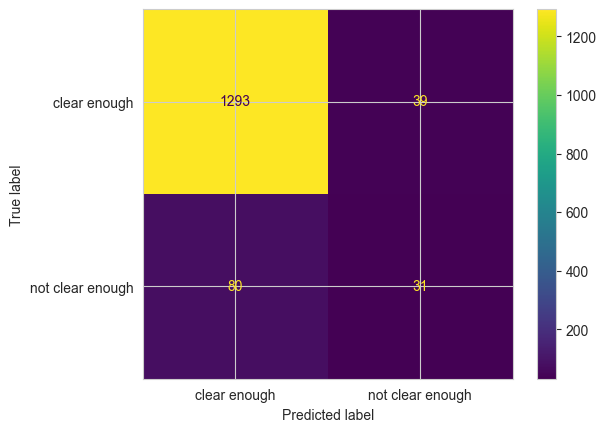

In [154]:
# Evaluate on validation data
val_predictions = best_clf.predict(X_val)

target_names = ["clear enough", "not clear enough"]

# Accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_val, val_predictions, target_names=target_names))

# Confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(best_clf, X_val, y_val, display_labels=target_names)

### Training on test(unseen) data ###

                  precision    recall  f1-score   support

    clear enough       0.93      0.97      0.95      1642
not clear enough       0.44      0.28      0.34       162

        accuracy                           0.90      1804
       macro avg       0.69      0.62      0.64      1804
    weighted avg       0.89      0.90      0.89      1804


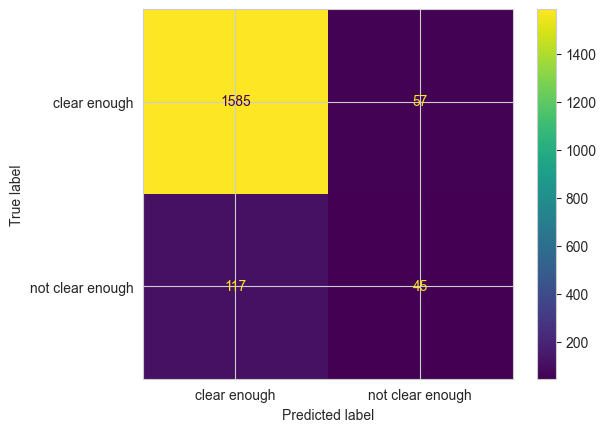

In [155]:
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test, display_labels=target_names)

### 2. Using CNN model ###

In [158]:
# Create a KerasClassifier wrapper for GridSearchCV
keras_model = KerasClassifier(build_fn=create_model)

pipeline = Pipeline([
    ('scaler', ct),
    ('clf', keras_model)
])

# Define hyperparameters to tune
param_grid = {
    'clf__epochs': [10, 20, 30, 40, 50, 60, 70, 80],
    'clf__batch_size': [32, 64, 128]
}

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3)
grid_search.fit(X_oversampled, y_oversampled)
best_clf = grid_search.best_estimator_

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Epoch 1/10
219/219 [==============================] - 1s 2ms/step - loss: 1.4112 - accuracy: 0.7710
Epoch 2/10
219/219 [==============================] - 0s 2ms/step - loss: 0.7107 - accuracy: 0.8840
Epoch 3/10
219/219 [==============================] - 1s 2ms/step - loss: 0.4825 - accuracy: 0.9237
Epoch 4/10
219/219 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.9387
Epoch 5/10
219/219 [==============================] - 0s 2ms/step - loss: 0.3123 - accuracy: 0.9516
Epoch 6/10
219/219 [==============================] - 0s 2ms/step - loss: 0.2761 - accuracy: 0.9603
Epoch 7/10
219/219 [==============================] - 0s 2ms/step - loss: 0.2461 - accuracy: 0.9671
Epoch 8/10
219/219 [==============================] - 0s 2ms/step - loss: 0.2279 - accuracy: 0.9694
Epoch 9/10
219/219 [==============================] - 0s 2ms/step - loss: 0.2286 - accuracy: 0.9691
Epoch 10/10
110/110 [==============================] - 0s 1ms/step
Epoch 1/10
219/219 [=============

In [159]:
clf_cnn_results = pd.DataFrame(grid_search.cv_results_)
clf_cnn_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__batch_size,param_clf__epochs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.410645,0.359458,0.377886,0.039387,32,10,"{'clf__batch_size': 32, 'clf__epochs': 10}",0.940840,0.941412,0.945111,0.942455,0.001893,21
1,15.479139,4.887443,1.033722,0.575658,32,20,"{'clf__batch_size': 32, 'clf__epochs': 20}",0.932266,0.940840,0.954545,0.942551,0.009175,20
2,19.952405,3.102326,0.784987,0.265742,32,30,"{'clf__batch_size': 32, 'clf__epochs': 30}",0.957131,0.951986,0.938822,0.949313,0.007710,18
3,20.698700,2.391691,0.427705,0.097620,32,40,"{'clf__batch_size': 32, 'clf__epochs': 40}",0.949700,0.957702,0.935678,0.947693,0.009103,19
4,27.678759,10.312049,0.323115,0.038908,32,50,"{'clf__batch_size': 32, 'clf__epochs': 50}",0.965990,0.952844,0.970269,0.963034,0.007414,8
5,23.824153,1.202116,0.314473,0.019628,32,60,"{'clf__batch_size': 32, 'clf__epochs': 60}",0.927694,0.965990,0.968839,0.954174,0.018761,16
6,32.734379,5.075484,0.599802,0.239259,32,70,"{'clf__batch_size': 32, 'clf__epochs': 70}",0.943127,0.920835,0.958548,0.940836,0.015481,22
7,35.389759,3.368425,0.319315,0.064370,32,80,"{'clf__batch_size': 32, 'clf__epochs': 80}",0.950557,0.933981,0.917095,0.933878,0.013661,24
8,5.029981,1.356365,0.348534,0.144062,64,10,"{'clf__batch_size': 64, 'clf__epochs': 10}",0.950557,0.961703,0.938822,0.950361,0.009342,17
9,9.146314,1.570943,0.463040,0.087262,64,20,"{'clf__batch_size': 64, 'clf__epochs': 20}",0.965133,0.954844,0.954831,0.958269,0.004853,12


In [160]:
print(clf_cnn_results[['mean_test_score'] + [t for t in clf_cnn_results.columns if 'param' in t]])

    mean_test_score param_clf__batch_size param_clf__epochs  \
0          0.942455                    32                10   
1          0.942551                    32                20   
2          0.949313                    32                30   
3          0.947693                    32                40   
4          0.963034                    32                50   
5          0.954174                    32                60   
6          0.940836                    32                70   
7          0.933878                    32                80   
8          0.950361                    64                10   
9          0.958269                    64                20   
10         0.934168                    64                30   
11         0.957126                    64                40   
12         0.960557                    64                50   
13         0.962938                    64                60   
14         0.969321                    64              

### Evaluation on  validation set ###

23/23 [==============================] - 0s 2ms/step
Validation Accuracy: 0.9057519057519058
Classification Report:
                  precision    recall  f1-score   support

    clear enough       0.95      0.95      0.95      1332
not clear enough       0.38      0.36      0.37       111

        accuracy                           0.91      1443
       macro avg       0.66      0.66      0.66      1443
    weighted avg       0.90      0.91      0.90      1443

Confusion Matrix:
23/23 [==============================] - 0s 2ms/step


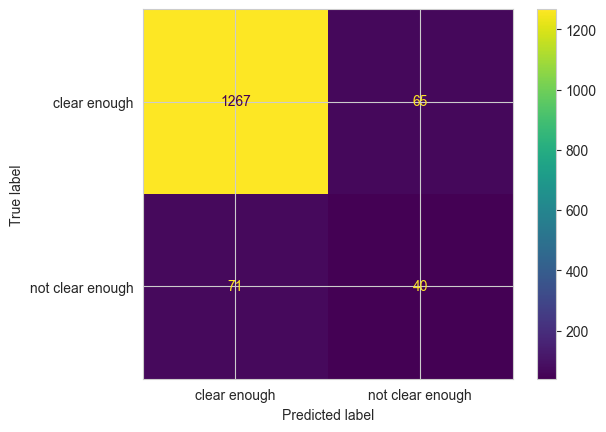

In [161]:
# Evaluate on validation data
val_predictions = best_clf.predict(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_val, val_predictions, target_names=target_names))

# Confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(best_clf, X_val, y_val, display_labels=target_names)

### Evaluation on test data ###

29/29 [==============================] - 0s 1ms/step
                  precision    recall  f1-score   support

    clear enough       0.94      0.95      0.95      1642
not clear enough       0.43      0.36      0.39       162

        accuracy                           0.90      1804
       macro avg       0.68      0.66      0.67      1804
    weighted avg       0.89      0.90      0.90      1804

29/29 [==============================] - 0s 2ms/step


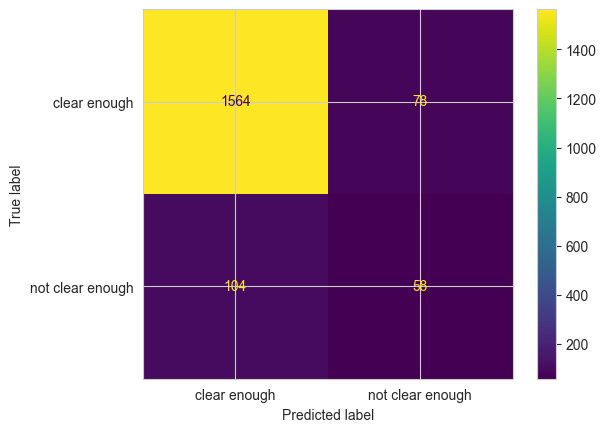

In [162]:
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test, display_labels=target_names)

###  3. Trying with SGDClassifier model ###

In [163]:
sgd_parameter = {'classifier__eta0': np.logspace(-5, -1, 3),
                 'classifier__learning_rate': ['constant'],
                 'classifier__alpha': [0.0001, 0.01, 0.1],
                 }

clf_pipe = Pipeline(
    steps=[('ct', ct),
           ('classifier', SGDClassifier(loss='log_loss', random_state=0)),
           ]
)

clf_search = GridSearchCV(clf_pipe, sgd_parameter, scoring="accuracy", cv=5)

clf_search.fit(X_oversampled, y_oversampled)
print("Best score: ", clf_search.best_score_, clf_search.best_params_)
print(f'Time elapsed is {(tt() - t0):.2f} seconds')

best_clf = clf_search.best_estimator_

Best score:  0.8458460037659657 {'classifier__alpha': 0.0001, 'classifier__eta0': 0.001, 'classifier__learning_rate': 'constant'}
Time elapsed is 2801.51 seconds


In [164]:
clf_sgd_results = pd.DataFrame(clf_search.cv_results_)
clf_sgd_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__eta0,param_classifier__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.411346,0.537910,0.152766,0.125595,0.0001,0.00001,constant,"{'classifier__alpha': 0.0001, 'classifier__eta...",0.692381,0.751787,0.725584,0.726536,0.730824,0.725422,0.019064,5
1,1.157800,0.598821,0.028113,0.003029,0.0001,0.001,constant,"{'classifier__alpha': 0.0001, 'classifier__eta...",0.846190,0.853740,0.846117,0.843735,0.839447,0.845846,0.004646,1
2,0.325254,0.008095,0.025424,0.001635,0.0001,0.1,constant,"{'classifier__alpha': 0.0001, 'classifier__eta...",0.728095,0.763221,0.750357,0.751310,0.735588,0.745714,0.012428,3
3,0.480745,0.034060,0.025084,0.000447,0.01,0.00001,constant,"{'classifier__alpha': 0.01, 'classifier__eta0'...",0.691905,0.750834,0.724154,0.724631,0.730824,0.724470,0.018953,6
4,0.522271,0.179548,0.035292,0.011103,0.01,0.001,constant,"{'classifier__alpha': 0.01, 'classifier__eta0'...",0.783333,0.799905,0.791329,0.777037,0.794188,0.789158,0.008079,2
5,0.414434,0.078999,0.029642,0.002088,0.01,0.1,constant,"{'classifier__alpha': 0.01, 'classifier__eta0'...",0.601429,0.641258,0.653168,0.608385,0.642211,0.629290,0.020463,8
6,0.645195,0.407283,0.028779,0.004564,0.1,0.00001,constant,"{'classifier__alpha': 0.1, 'classifier__eta0':...",0.686667,0.745593,0.718437,0.719867,0.726536,0.719420,0.019024,7
7,0.369371,0.134202,0.041017,0.015515,0.1,0.001,constant,"{'classifier__alpha': 0.1, 'classifier__eta0':...",0.730000,0.776560,0.732730,0.743687,0.738447,0.744285,0.016815,4
8,0.288738,0.082330,0.029785,0.006883,0.1,0.1,constant,"{'classifier__alpha': 0.1, 'classifier__eta0':...",0.593810,0.567889,0.552168,0.505955,0.509290,0.545822,0.033923,9


In [165]:
print(clf_sgd_results[['mean_test_score'] + [t for t in clf_sgd_results.columns if 'param' in t]])

   mean_test_score param_classifier__alpha param_classifier__eta0  \
0         0.725422                  0.0001                0.00001   
1         0.845846                  0.0001                  0.001   
2         0.745714                  0.0001                    0.1   
3         0.724470                    0.01                0.00001   
4         0.789158                    0.01                  0.001   
5         0.629290                    0.01                    0.1   
6         0.719420                     0.1                0.00001   
7         0.744285                     0.1                  0.001   
8         0.545822                     0.1                    0.1   

  param_classifier__learning_rate  \
0                        constant   
1                        constant   
2                        constant   
3                        constant   
4                        constant   
5                        constant   
6                        constant   
7            

### Evaluation on validation data ###

Validation Accuracy: 0.8184338184338185
Classification Report:
                  precision    recall  f1-score   support

    clear enough       0.97      0.83      0.89      1332
not clear enough       0.25      0.66      0.36       111

        accuracy                           0.82      1443
       macro avg       0.61      0.74      0.63      1443
    weighted avg       0.91      0.82      0.85      1443

Confusion Matrix:


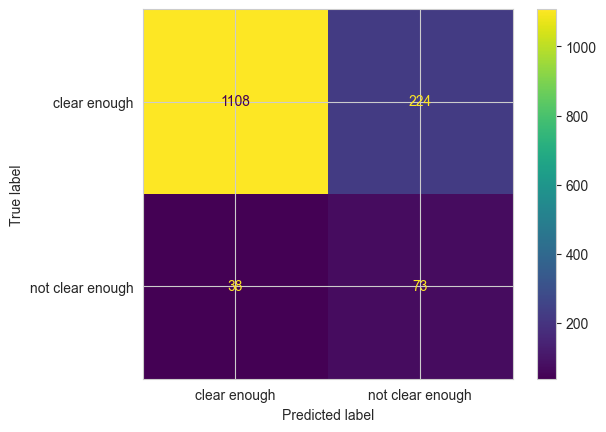

In [166]:
# Evaluate on validation data
val_predictions = best_clf.predict(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_val, val_predictions, target_names=target_names))

# Confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(best_clf, X_val, y_val, display_labels=target_names)


### Evaluation on test data ###

                  precision    recall  f1-score   support

    clear enough       0.96      0.82      0.88      1642
not clear enough       0.25      0.63      0.36       162

        accuracy                           0.80      1804
       macro avg       0.61      0.72      0.62      1804
    weighted avg       0.89      0.80      0.84      1804


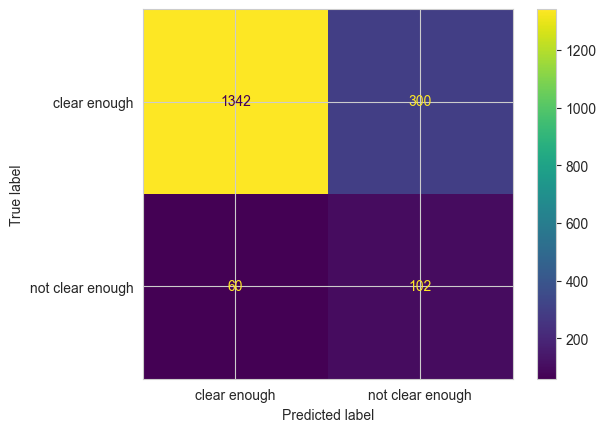

In [167]:
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test, display_labels=target_names)

### Questions ###

### 1. Can i use semi supervised learning to label paragraphs ###
https://huggingface.co/docs/transformers/en/model_doc/xlnet

### Add references for the code, in notebook and in report too ###

### Reasons ###



this text was labelled like clear enough 
"Ramsay was born in Glasgow on 2 October 1852. He was a nephew of the geologist Sir Andrew Ramsay. His father, William, Sr., was a civil engineer. His mother was Catherine Robertson. He studied at Glasgow Academy, at the University of Glasgow and at University of Tubingen in Germany. "
and this one was labelled as not clear enough 
"It has been widely estimated for at least the last generation that all the programs and resources devoted to ensuring access to justice address only 20% of the civil legal needs of low-income people in the United States. Drawing on this experience, in late 2011, the U.S. government-funded Legal Services Corporation decided to convene a summit of leaders to explore how best to use technology in the access-to-justice community. The group adopted a mission for The Summit on the Use of Technology to Expand Access to Justice  consistent with the magnitude of the challenge: "to explore the potential of technology to move the United States toward providing some form of effective assistance to 100% of persons otherwise unable to afford an attorney for dealing with essential civil legal needs".In April 2017, joined by Microsoft and Pro Bono Net, the Legal Services Corporation  announced a pilot program to develop online, statewide legal portals to direct individuals with civil legal needs to the most appropriate forms of assistance."

so what do you think what are the reasons ?
ChatGPT
The first text about Ramsay's background is labeled as clear enough because it provides straightforward information about Ramsay's birth, family background, education, and academic institutions he attended. The information is presented in a concise and organized manner, making it easy to understand.

The second text, on the other hand, is labeled as not clear enough because it contains more complex information and concepts. It discusses the issue of access to justice, the efforts made by the Legal Services Corporation, and the involvement of other entities like Microsoft and Pro Bono Net in a pilot program. However, the text may be difficult to understand for some readers due to the following reasons:

Complexity of the Topic: The text discusses a complex social issue – access to justice for low-income individuals – which may require background knowledge or explanation for readers unfamiliar with the topic.

Technical Jargon: The text includes terms like "access-to-justice community," "statewide legal portals," and "civil legal needs," which may be unfamiliar to some readers and require clarification.

Lack of Context: The text jumps into the issue without providing sufficient context or background information, assuming that the reader is already familiar with the topic and previous efforts.

Length and Sentence Structure: The text contains long sentences and dense paragraphs, which can make it challenging for readers to follow the main points and understand the message clearly.

Overall, while the second text addresses an important and complex topic, it may benefit from simplifying the language, providing more context, and breaking down the information into smaller, more digestible chunks for better comprehension.